# Quantum Photonic Transformer (QPT): 2D Pointwise Spiral Classification
## Alkin Kaz, April 2023

## 1) Setting up the Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset # for the mesh

import matplotlib.pyplot as plt
import matplotlib.patches as patches # for the rectangle
# %matplotlib inline
# plt.style.use('dark_background')

import numpy as np

import warnings
import datetime
import os
import json


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import pandas as pd

In [17]:
# !pip install -q strawberryfields --upgrade

import strawberryfields as sf
from strawberryfields.ops import *

In [18]:
# !pip install -q tqdm
import tqdm

In [3]:
# setting device on GPU if available, else CPU
# note: if you want to use GPU, select "Runtime > Change runtime type" from above
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()
print(f"CPU Count: {os.cpu_count()}")

Using device: cuda:0

CPU Count: 16


In [13]:
# !pip install -q -U ray[air]
import ray
ray.init()

2023-04-25 15:05:33,879	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8265


## 2) Spiral Datasets

### 2.1) The SpiralDataset class

In [14]:
############################################################################
# Start Citation: Taken from personal communication with Gerry Angelatos   #
############################################################################
def Spiral_sample2(dW, Ns, ts=0, Nturns=3, Sep=0.05, seed=100):
    """
    Generates sample of a 2d spiral with N turns and standard deviation dw
    This version '2' adds noise normal to the spiral line (ie radial white noise)
    and normalizes the dataset relative so the noise free set is in [-1, 1]x2
    Parameters
    -----------
    dW
        width of spiral arms (noise strength),
        scales with the number of turns, so strength of 1
        gives about ~90% probability of falling in the correct arm
    Ns
        number of uniformly distributed points in spiral
    ts
        starting point (radians) relative to y-axis
    Nturns
        number of turns (radians/pi)
    Sep
        starting displacement from origin
    seed
        random seed so dataset is repeateable
    Returns
    ----------
    np.array
       (2 x Ns) array of uniform samples over spiral length,
       normally distributed at specific angle
    """
    rs = np.random.RandomState(seed=seed + int(ts*100))
    theta = np.sqrt(rs.rand(Ns)) * Nturns * np.pi
    r = theta + np.pi*Sep
    spiral = np.array([(np.cos(ts)*np.cos(theta) - np.sin(ts)*np.sin(theta)) * r,
                      (np.sin(ts)*np.cos(theta) + np.cos(ts)*np.sin(theta)) * r])
    # normal vector to each point
    Norm = np.array([spiral[0]-spiral[1]/r, spiral[1]-spiral[0]/r])
    # add noise, normalize
    return (spiral + (dW * Norm / np.sqrt(Norm[0]**2 + Norm[1]**2))\
            * rs.randn(1, Ns))/np.max(np.abs(spiral))

############################################################################
# End Citation: Taken from personal communication with Gerry Angelatos     #
############################################################################

In [15]:
class SpiralDataset(Dataset):
    """
        The pointwise classification problem means that we have an input
        dataset x of dimensions [N_spiral x 1+D_spiral x 1] where:
        - N_spiral is the number of "sequences,"
        - D_spiral is the length of the sentence/sequence,
            and +1 is for the dummy classification token (see EncoderClassifier)
        - 1 is the dimension of every "word" in this sequence.

        The corresponding ground truth outputs for this sequence is y and of
        dimensions [N_spiral x num_class], where we have a probability
        distribution for every "sequence" (i.e., point).

    """

    def __init__(
        self,
        D_spiral,
        N_spiral,
        cphase: list = [0, 1],
        Nturns: int = 4,
        Sep: float = 0.05,
        W: float = 0.5,
        seed: int = 100,
        device: torch.device = 'cpu'
    ):
        self.spiral_params = {
            "D_spiral": D_spiral,
            "N_spiral": N_spiral,
            "cphase": cphase,  # starting angles, units of pi
            "Nturns": Nturns,  # number of pi/2 rotations per spiral arm
            "Sep": Sep,  # separation of arms at origin (small, positive)
            "W": W,  # relative width of spiral arms due to noise
            "seed": seed,
            "device": device
        }

        ################################################
        # Start Citation: Adapted from Gerry Angelatos #
        ################################################

        # generate input set from each class
        x_spiral0 = Spiral_sample2(
            W, int(N_spiral/2), ts=cphase[0]*np.pi, Nturns=Nturns, Sep=Sep,
            seed=seed).T
        x_spiral1 = Spiral_sample2(
            W, int(N_spiral/2), ts=cphase[1]*np.pi, Nturns=Nturns, Sep=Sep,
            seed=seed).T
        # concatenate to 1 dataset
        x_spiral = np.vstack((x_spiral1, x_spiral0))

        # class labels, assign to class 1 if in spiral 1, assign to class 0 if in spiral 0
        #   => probability simplex: class 0: [1, 0], class 1: [0, 1]
        self.y = torch.zeros((N_spiral, 2), device=device)
        self.y[:N_spiral//2, 1] += 1
        self.y[N_spiral//2:, 0] += 1

        ################################################
        # End Citation: Adapted from Gerry Angelatos   #
        ################################################

        x_spiral = np.expand_dims(x_spiral, axis=2)

        self.x = torch.from_numpy(x_spiral).to(
            dtype=torch.float32, device=device)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __str__(self):
        return f"{self.spiral_params}"

### 2.2) Train, Validation, and Test Datasets
Note that [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) is a useful abstraction for automatically loading different batches of data into the training loop, for

1.   randomly shuffling the order of the data once the current training epoch is exhausted (see the `shuffle=True` option),
2.   picking multiple datapoints at once (see the `batch_size` option).



In [405]:
train_data_params = {
    "D_spiral": 2,
    "N_spiral": 8192, # changed from 1024
    "cphase": [0, 1],
    "Nturns": 4,
    "Sep": 0.05,
    "W": 0.5, # changed from 0.5
    "seed": 100,
    "device": device
}

val_data_params = {
    "D_spiral": 2,
    "N_spiral": 2048, # changed from 512
    "cphase": [0, 1],
    "Nturns": 4,
    "Sep": 0.05,
    "W": 0.5, # changed from 0.5
    "seed": 101,
    "device": device
}

test_data_params = {
    "D_spiral": 2,
    "N_spiral": 2048, # changed from 512
    "cphase": [0, 1],
    "Nturns": 4,
    "Sep": 0.05,
    "W": 0.5,
    "seed": 102,
    "device": device
}

In [406]:
# The batch dimension for parallel training (batch of points, where every point is a two-word long sequence)
BATCH_SIZE = 2048

In [407]:
train_dataset = SpiralDataset(**train_data_params)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SpiralDataset(**val_data_params)
val_loader = DataLoader(val_dataset, batch_size=val_data_params["N_spiral"], shuffle=True)

test_dataset = SpiralDataset(**test_data_params)
test_loader = DataLoader(test_dataset, batch_size=test_data_params["N_spiral"], shuffle=True)

## 3) The Model Classes

### 3.1) Quantum Circuitry for Gaussian RBF (Q-RBF)

#### 3.1.1) Implementation and Testing of the Scalar Function

In [16]:
def quantum_rbf_scalar(u1, u2, is_u1_input: bool=True, shots: int=16, 
                       eng: sf.Engine=sf.Engine('gaussian')):
    """
        The quantum photonics circuitry, implementing the quantum communication
        protocol described in Banazsek (1999) but now used for finding the
        Gaussian RBF kernel between two scalars u1 and u2

        Arguments:
        - u1 and u2: coherent states used for the protocol
        - is_u1_input: sets the input rail to the desired input state
        - shots: number of shots the circuit is run for statistics
        - eng: the strawberryfields engine that will run the simulation on

        Returns:
        - the probability that no photon is observed in any photodetector,
        equally $\exp(-\abs{u_1 - u_2}^2 / 2)$ but with additional "noise."
    """
    prog = sf.Program(2)
    with prog.context as q:

        Vac | q[1]

        if is_u1_input:
            Coherent(u1) | q[0]
        else:
            Coherent(u2) | q[0]

        BSgate() | q

        # the wires are "swapped"
        Dgate(-u1/np.sqrt(2)) | q[1]
        Dgate(-u2/np.sqrt(2)) | q[0]

        MeasureFock() | (q[0], q[1])
    
    if eng.backend.circuit is not None:
        eng.reset()

    # to catch the UserWarning due to non-Gaussian Fock basis measurement
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        run = eng.run(prog, shots=shots)

    # check if all elements in each row are == 0
    bool_arr = np.all(run.samples == 0, axis=1)
    # convert boolean results to integers
    results = bool_arr.astype(int)

    return results.mean()


NameError: name 'sf' is not defined

In [12]:
box_half_width = 1.5
mesh_points = 16
num_shots = 16
engine = sf.Engine('gaussian')

u1_arr = np.linspace(-box_half_width, box_half_width, mesh_points)
u2_arr = np.linspace(-box_half_width, box_half_width, mesh_points)

rbf_u1_in = np.asarray([[quantum_rbf_scalar(u1, u2, is_u1_input=True, shots=num_shots) for u2 in u2_arr] for u1 in u1_arr])
rbf_u2_in = np.asarray([[quantum_rbf_scalar(u1, u2, is_u1_input=False, shots=num_shots) for u2 in u2_arr] for u1 in u1_arr])
ground_rbf = np.asarray([[np.exp(-(u1-u2)**2 /2) for u2 in u2_arr] for u1 in u1_arr])

u1_arr_mesh, u2_arr_mesh = np.meshgrid(u1_arr, u2_arr)

In [23]:
def scalar_rbf_plotter(u1_mesh, u2_mesh, rbf_arr, title_str, save_path=None, save_pdf: bool=False):
    fig, ax = plt.subplots()

    scatter = ax.scatter(u1_mesh, u2_mesh, c=rbf_arr, cmap="RdYlGn")

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("$\\alpha_1$")
    ax.set_ylabel("$\\alpha_2$")
    
    plt.colorbar(scatter, ax=ax)
    ax.set_title(title_str)

    if save_pdf:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

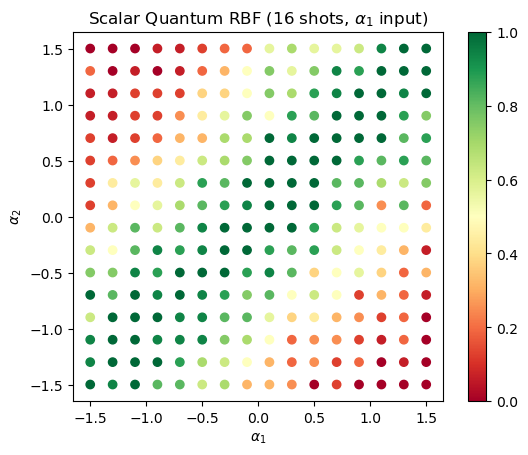

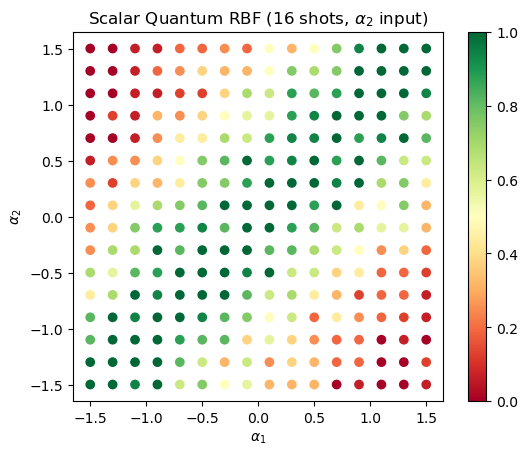

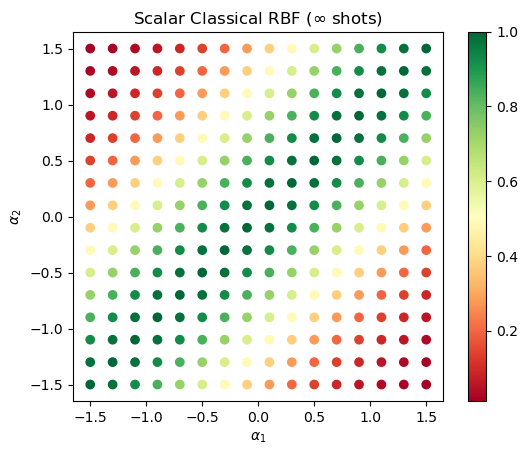

In [25]:
scalar_rbf_plotter(u1_arr_mesh, u2_arr_mesh, rbf_u1_in, f"Scalar Quantum RBF ({num_shots} shots, $\\alpha_1$ input)", "plots/u1_input.pdf", True)
scalar_rbf_plotter(u1_arr_mesh, u2_arr_mesh, rbf_u2_in, f"Scalar Quantum RBF ({num_shots} shots, $\\alpha_2$ input)", "plots/u2_input.pdf", True)
scalar_rbf_plotter(u1_arr_mesh, u2_arr_mesh, ground_rbf, f"Scalar Classical RBF ($\infty$ shots)", "plots/cRBF.pdf", True)

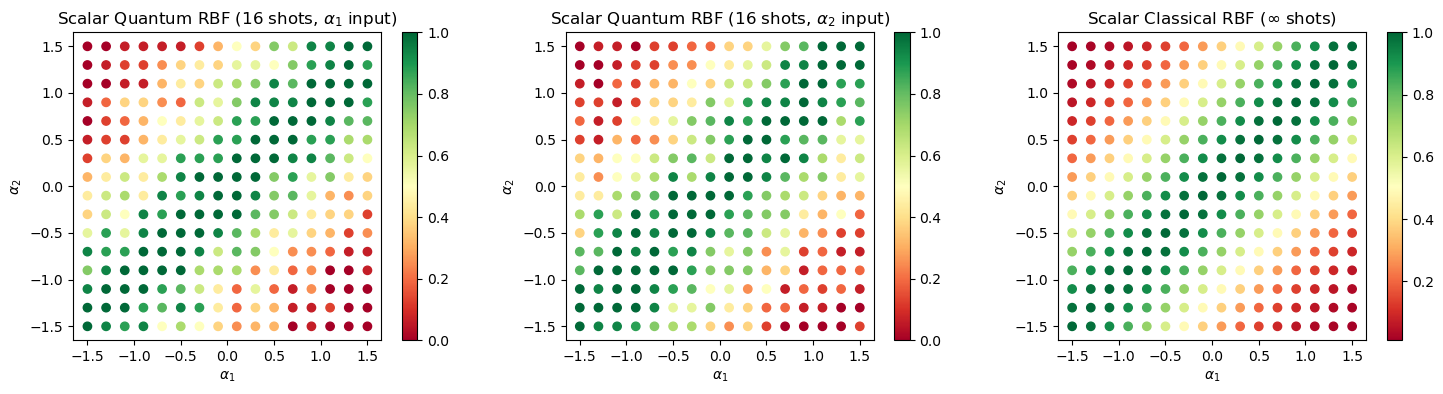

In [24]:
fig, axs = plt.subplots(1, 3)

scatter0 = axs[0].scatter(u1_arr_mesh, u2_arr_mesh, c=rbf_u1_in, cmap="RdYlGn")
scatter1 = axs[1].scatter(u1_arr_mesh, u2_arr_mesh, c=rbf_u2_in, cmap="RdYlGn")
scatter2 = axs[2].scatter(u1_arr_mesh, u2_arr_mesh, c=ground_rbf, cmap="RdYlGn")

for ax in axs:
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("$\\alpha_1$")
    ax.set_ylabel("$\\alpha_2$")

plt.colorbar(scatter0, ax=axs[0])
plt.colorbar(scatter1, ax=axs[1])
plt.colorbar(scatter2, ax=axs[2])

axs[0].set_title(f"Scalar Quantum RBF ({num_shots} shots, $\\alpha_1$ input)")
axs[1].set_title(f"Scalar Quantum RBF ({num_shots} shots, $\\alpha_2$ input)")
axs[2].set_title(f"Scalar Classical RBF ($\infty$ shots)")

# fig.set_size_inches(9.6, 10)
fig.set_size_inches(18, 4)
plt.draw()

In [29]:
shots_arr = [2**k for k in range(6)]
rbf_arr = []

for shot_cnt in tqdm.tqdm(shots_arr, desc="Progress"):
    rbf_arr.append(np.asarray([[quantum_rbf_scalar(u1, u2, shots=shot_cnt)\
                                for u2 in u2_arr] for u1 in u1_arr]))

Progress: 100%|██████████| 6/6 [00:19<00:00,  3.18s/it]


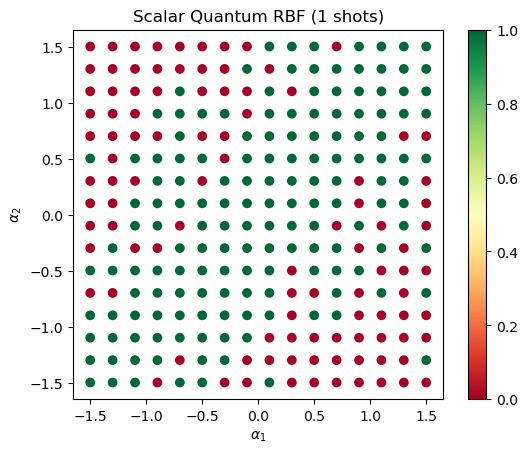

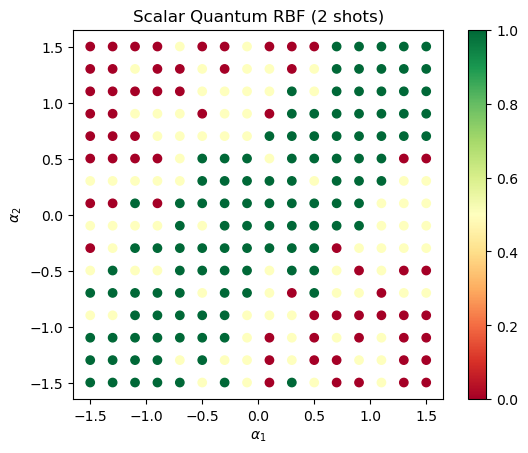

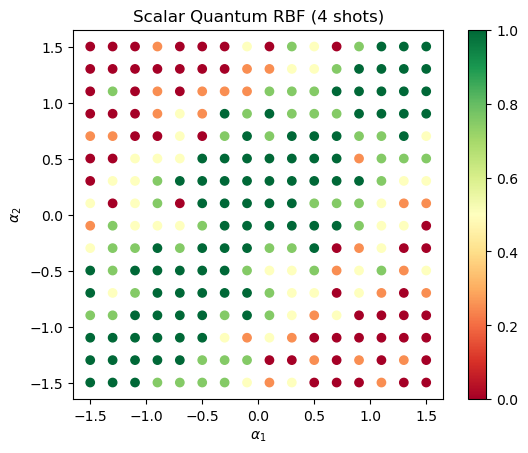

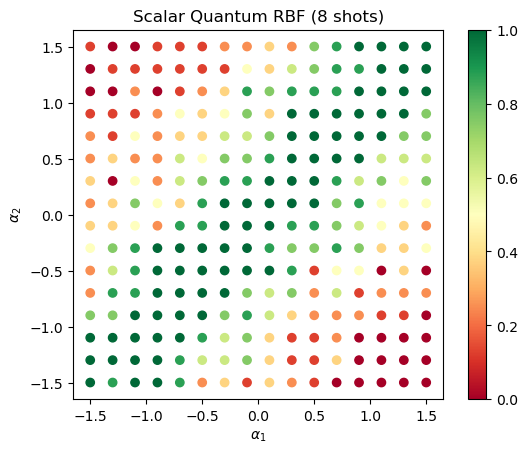

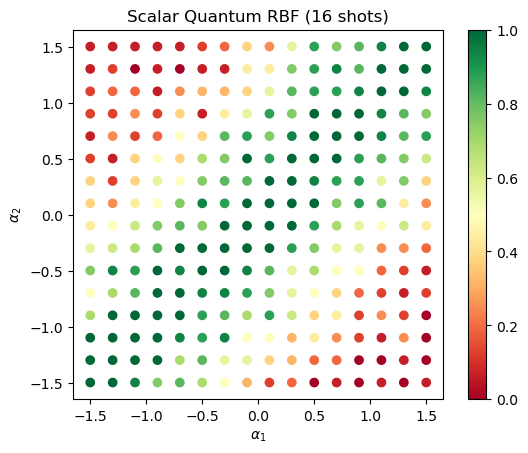

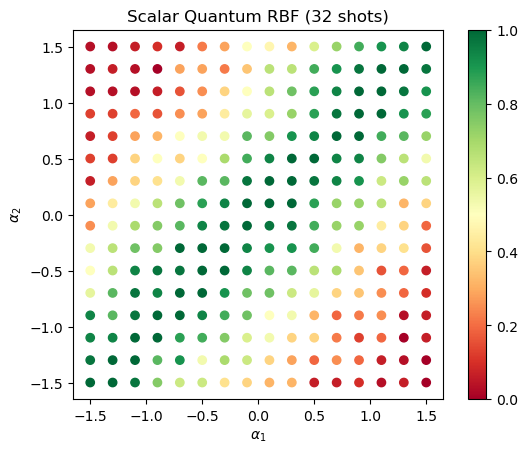

In [30]:
for i in range(len(shots_arr)):
    scalar_rbf_plotter(u1_arr_mesh, u2_arr_mesh, rbf_arr[i], f"Scalar Quantum RBF ({shots_arr[i]} shots)", f"plots/qRBF_shots/{shots_arr[i]}_shots.pdf", True)

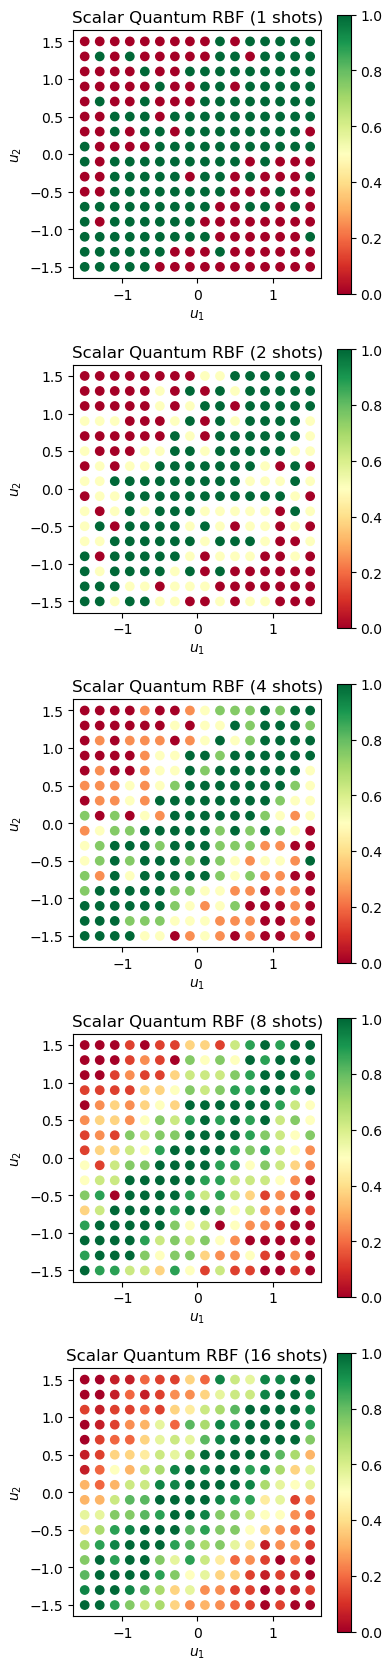

In [27]:
fig, axs = plt.subplots(len(shots_arr), 1)

for i in range(len(shots_arr)):
    scatter = axs[i].scatter(u1_arr_mesh, u2_arr_mesh, c=rbf_arr[i], cmap="RdYlGn")

    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_xlabel("$u_1$")
    axs[i].set_ylabel("$u_2$")
    axs[i].set_title(f"Scalar Quantum RBF ({shots_arr[i]} shots)")

    plt.colorbar(scatter, ax=axs[i])

fig.set_size_inches(4, 4.2*len(shots_arr))
plt.draw()

#### 3.1.2) Vector Q-RBF

In [13]:
def quantum_rbf(u1: torch.Tensor, u2: torch.Tensor,
                is_u1_input: bool=True, shots: int=1,
                eng: sf.Engine=sf.Engine('gaussian')):
    """
        This is simply a vector variation of the quantum_rbf_scalar()
        
        function, applied elementwise for the two input tensors u1 and u2 and
        multiplied at the end.
        Hence, refer to quantum_rbf_scalar() for further description.

        Arguments:
        - u1 and u2: vectors as torch Tensors

        Output:
        - results: scalar, "the similarity"
    """

    u1_np = u1.cpu().detach().numpy().flatten()
    u2_np = u2.cpu().detach().numpy().flatten()
    result = 1
    
    for i in range(u1_np.shape[0]):
        result *= quantum_rbf_scalar(u1_np[i], u2_np[i], is_u1_input, shots, eng) 

    return result

#### 3.1.3) Parallelized Quantum Simulation via Ray

We will first define the parallelized quantum functions to later compare
the performance against vanilla implementation.

In [19]:
@ray.remote
def quantum_rbf_scalar_ray(u1, u2, is_u1_input: bool = True, shots: int = 16):
    
    prog = sf.Program(2)

    with prog.context as q:

        Vac | q[1]

        if is_u1_input:
            Coherent(u1) | q[0]
        else:
            Coherent(u2) | q[0]

        BSgate() | q

        # the wires are "swapped"
        Dgate(-u1/np.sqrt(2)) | q[1]
        Dgate(-u2/np.sqrt(2)) | q[0]

        MeasureFock() | (q[0], q[1])

        eng = sf.Engine('gaussian')
        if eng.backend.circuit is not None:
            eng.reset()
        # to catch the UserWarning due to non-Gaussian Fock basis measurement
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            run = eng.run(prog, shots=shots)

        bool_arr = np.all(run.samples == 0, axis=1)
        # convert boolean results to integers
        results = bool_arr.astype(int)

        return results.mean()

In [20]:
def quantum_rbf_ray(u1: torch.Tensor, u2: torch.Tensor, is_u1_input=True, shots=2):
    """
    This is simply a vector variation of the quantum_rbf_scalar()
    function, applied elementwise for the two input tensors u1 and u2 and
    multiplied at the end.
    Hence, refer to quantum_rbf_scalar() for further description.

    Arguments:
    - u1 and u2: vectors as torch Tensors

    Output:
    - results: scalar, "the similarity"
    """
    u1_np = u1.cpu().detach().numpy().flatten()
    u2_np = u2.cpu().detach().numpy().flatten()

    result_ids = []
    for i in range(u1_np.shape[0]):
        result_ids.append(quantum_rbf_scalar_ray.remote(
            u1_np[i], u2_np[i], is_u1_input, shots))

    results = ray.get(result_ids)
    return np.prod(results)

In [16]:
import timeit

def time_gaussian(shots: int=4, input_len: int=2, is_parallelized: bool=False):
    # Define the shape of the tensor
    shape = (input_len)

    # Create the tensor with uniform initialization
    u_1 = torch.empty(shape)
    u_2 = torch.empty(shape)

    torch.nn.init.uniform_(u_1)
    torch.nn.init.uniform_(u_2)

    f = quantum_rbf_ray if is_parallelized else quantum_rbf
    return timeit.timeit(lambda: f(u_1, u_2, shots=shots), number=4)

In [18]:
shots_arr = [2**k for k in range(7)]
input_len_arr = [2**k for k in range(7)]

shots_np = np.asarray(shots_arr).reshape(-1, 1)
len_np = np.asarray(input_len_arr).reshape(-1, 1)

example_shots = 8
example_len = 16

In [22]:
exec_t_arr_ray = np.asarray([time_gaussian(example_shots, l, True) for l in input_len_arr])
exec_t_arr_van = np.asarray([time_gaussian(example_shots, l, False) for l in input_len_arr])

In [25]:
lm_len_van = LinearRegression()
lm_len_ray = LinearRegression()

lm_len_van.fit(len_np, exec_t_arr_van)
lm_len_ray.fit(len_np, exec_t_arr_ray)

slope_len_van = lm_len_van.coef_[0]
slope_len_ray = lm_len_ray.coef_[0]

print(f"Vanilla Slope: {slope_len_van}")
print(f"Ray Slope: {slope_len_ray}")
print(f"Reduction Ratio: {100*(1-slope_len_ray/slope_len_van)} %")

Vanilla Slope: 0.03843598006607189
Ray Slope: 0.017894014042002446
Reduction Ratio: 53.44462659403395 %


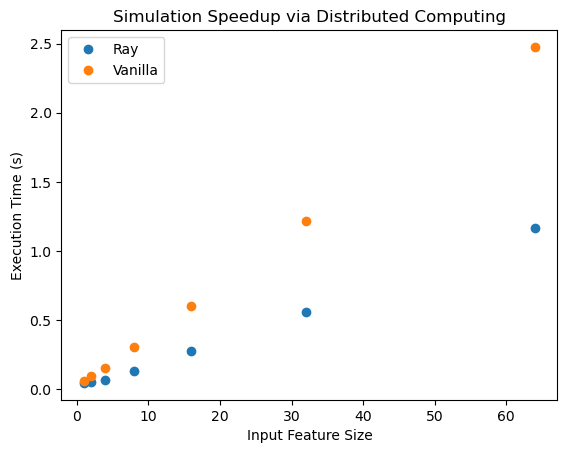

In [32]:
fig, ax = plt.subplots()

ax.plot(input_len_arr, exec_t_arr_ray, 'o', label="Ray")
ax.plot(input_len_arr, exec_t_arr_van, 'o', label="Vanilla")

ax.set_title("Simulation Speedup via Distributed Computing")
ax.set_xlabel("Input Feature Size")
ax.set_ylabel("Execution Time (s)")
ax.legend()

plt.show()
# plt.savefig("plots/ray/input_len.pdf", bbox_inches="tight")

In [27]:
shots_exec_t_arr_ray = [time_gaussian(s, example_len, True) for s in shots_arr]
shots_exec_t_arr_van = [time_gaussian(s, example_len, False) for s in shots_arr]

In [28]:
lm_shots_van = LinearRegression()
lm_shots_ray = LinearRegression()

lm_shots_van.fit(shots_np, shots_exec_t_arr_van)
lm_shots_ray.fit(shots_np, shots_exec_t_arr_ray)

slope_shots_van = lm_shots_van.coef_[0]
slope_shots_ray = lm_shots_ray.coef_[0]

print(f"Vanilla Slope: {slope_shots_van}")
print(f"Ray Slope: {slope_shots_ray}")
print(f"Reduction Ratio: {100*(1-slope_shots_ray/slope_shots_van)} %")

Vanilla Slope: 0.07493294744773524
Ray Slope: 0.029301642243635784
Reduction Ratio: 60.896183532519785 %


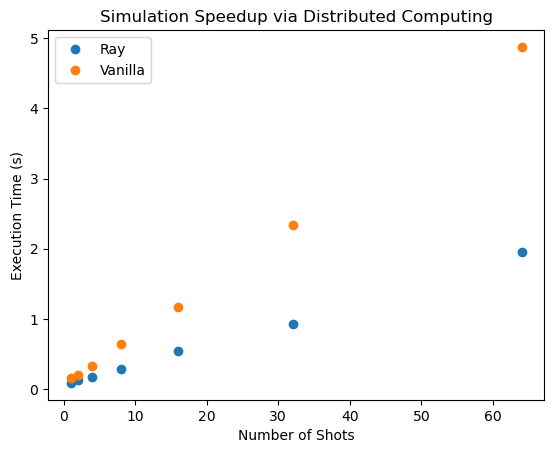

In [31]:
fig, ax = plt.subplots()

ax.plot(shots_arr, shots_exec_t_arr_ray, 'o', label="Ray")
ax.plot(shots_arr, shots_exec_t_arr_van, 'o', label="Vanilla")

ax.set_title("Simulation Speedup via Distributed Computing")
ax.set_xlabel("Number of Shots")
ax.set_ylabel("Execution Time (s)")
ax.legend()

plt.show()
# plt.savefig("plots/ray/shots.pdf", bbox_inches="tight")

#### 3.1.4) Differentiable Torch Function

For enabling gradient flow over the network, we will simply use the gradient of the classical Gaussian RBF to define a custom autograd function. First, let's compare our analytical gradient to the autodifferentiated gradient for the classical RBF.

In [21]:
def classic_rbf_fwd(u1: torch.Tensor, u2: torch.Tensor) -> torch.Tensor:
    diff = u1 - u2
    norm_sq = torch.sum(torch.pow(torch.norm(diff, dim=-1), 2))
    return torch.exp(-norm_sq / 2)

def classic_rbf_bwd(u1: torch.Tensor, u2: torch.Tensor, grad_output: torch.Tensor):
    diff = u1 - u2
    norm_sq = torch.sum(torch.pow(torch.norm(diff, dim=-1), 2))
    exp_term = torch.exp(-norm_sq / 2)
    grad_norm_sq = -torch.norm(diff, dim=-1, keepdim=True) ** 2
    grad_u1 = grad_output.unsqueeze(-1) * diff * exp_term * grad_norm_sq / norm_sq
    grad_u2 = -grad_u1
    return grad_u1, grad_u2

u1 = torch.tensor([4.0, 5.0, 7.2, 8.9], requires_grad=True, device=device)
u2 = torch.tensor([4.0, 5.0, 7.0, 9.0], requires_grad=True, device=device)

output_cRBF = classic_rbf_fwd(u1, u2)
output_qRBF = quantum_rbf_ray(u1, u2, shots=64)
print(f"cRBF output: {output_cRBF}")
print(f"qRBF output: {output_qRBF}")

ones = torch.ones_like(output_cRBF)
output_cRBF.backward(ones)

print("="*10, "autodifferentiated grad", "="*10)
print(u1.grad)
print(u2.grad)

grad_u1, grad_u2 = classic_rbf_bwd(u1, u2, ones)

print("="*10, "analytical grad", "="*10)
print(grad_u1)
print(grad_u2)

cRBF output: 0.9753099083900452
qRBF output: 0.984375
========== autodifferentiated grad ==========
tensor([-0.0000, -0.0000, -0.1951,  0.0975], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.1951, -0.0975], device='cuda:0')
========== analytical grad ==========
tensor([-0.0000, -0.0000, -0.1951,  0.0975], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.0000,  0.0000,  0.1951, -0.0975], device='cuda:0',
       grad_fn=<NegBackward0>)


In [22]:
def classic_rbf_fwd_batched(u1: torch.Tensor, u2: torch.Tensor) -> torch.Tensor:
    dist = torch.cdist(u1, u2)
    return torch.exp(-torch.pow(dist, 2) / 2)

In [23]:
class QuantumRBF(Function):
    @staticmethod
    def forward(ctx, u1, u2):
        # Perform the forward pass
        # note that due to the observed performance increase,
        # we are using the distributed version.
        y = quantum_rbf_ray(u1, u2)
        
        # Save the input tensors u1 and u2 for the backward pass
        ctx.save_for_backward(u1, u2)
        
        return y

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve the input tensors u1 and u2 from the context
        u1, u2 = ctx.saved_tensors
        
        # Compute the gradients of the function with respect to u1 and u2
        grad_u1, grad_u2 = classic_rbf_bwd(u1, u2, grad_output)
        
        return grad_u1, grad_u2

### 3.2) Transformer Encoder

In [27]:
class SelfAttentionLayer(nn.Module):
    """
    The Self-Attention Layer takes in a batch of input x
    of dimension (batch_size, seq_length, in_dim).

    It uses the projection layers
        W_Q (in_dim, hidden_dim): query projection
        W_K (in_dim, hidden_dim): key projection
        W_V (in_dim, out_dim): value projection

    which has a bias term added for convenience (e.g., x' = W_Q @ x + b_Q)
    and applies the attention mechanism to every batch, resulting in an output
    of (batch_size, seq_length, out_dim): every row is the "attended" value
    vector for a given query.
    
    The implemented non-linearities for the attention are:
    - "softmax": The Softmax function, normalized over the key dimensions.
    - "relu": The element-wise ReLU function.
    - "gelu": The element-wise GeLU function.
    - "cRBF": The classical Gaussian RBF.
    - "qRBF": The quantum Gaussian RBF.
    - "none": No non-linearity.

    """

    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int,
                 device: torch.device, nonlinearity: str="softmax") -> None:
        super().__init__()

        # note that we can also use bias=True but that will probably
        # complicate the analytical calculations
        
        self.W_Q = nn.Linear(in_dim, hidden_dim, bias=False, device=device)
        self.W_K = nn.Linear(in_dim, hidden_dim, bias=False, device=device)
        self.W_V = nn.Linear(in_dim, out_dim, bias=False, device=device)

        self.nonlinearity = nonlinearity
        if nonlinearity == "qRBF":
            self.qRBF = QuantumRBF()

    def forward(self, x, return_attention_weights=False):

        query = self.W_Q(x) # [batch_size x seq_length x hidden_dim]
        key = self.W_K(x) # [batch_size x seq_length x hidden_dim]
        value = self.W_V(x) # [batch_size x seq_length x out_dim]

        # attention_scores: [batch_size x seq_length x seq_length]

        if self.nonlinearity == "cRBF":
            attention_scores = classic_rbf_fwd_batched(query, key)
            attention_weights = attention_scores
        elif self.nonlinearity == "qRBF":
            attention_scores = torch.zeros((x.size(0), x.size(1), x.size(1)),
                                           device=device)
            for seq in range(x.size(0)):
                for from_token in range(x.size(1)):
                    for to_token in range(x.size(1)):
                        attention_scores[seq][from_token][to_token] = self.qRBF.apply(query[seq][from_token], key[seq][to_token])

            attention_weights = attention_scores
        else:
            attention_scores = torch.matmul(query, key.transpose(-2, -1))
            attention_scores /= torch.sqrt(torch.tensor(self.W_Q.out_features, dtype=torch.float))

            # different variations of the architecture:
            if self.nonlinearity == "softmax":
                attention_weights = F.softmax(attention_scores, dim=-1)
            elif self.nonlinearity == "relu":
                attention_weights = F.relu(attention_scores)
            elif self.nonlinearity == "gelu":
                attention_weights = F.gelu(attention_scores)
            elif self.nonlinearity == "none":
                attention_weights = attention_scores

        attended_value = torch.matmul(attention_weights, value)

        if return_attention_weights:
            return attended_value, attention_weights
        else:
            return attended_value


class MultiheadAttention(nn.Module):

    def __init__(self, num_heads=int, dim_model=int, device=torch.device,
                 attn_nonlinearity: str="softmax"):
        super().__init__()

        self.attention_heads = []
        for head_idx in range(num_heads):
            self.attention_heads.append(
                SelfAttentionLayer(
                    dim_model,
                    dim_model // num_heads,
                    dim_model // num_heads,
                    device,
                    nonlinearity=attn_nonlinearity
                )
            )
        self.attention_heads = nn.ModuleList(self.attention_heads)

    def forward(self, x, return_attention_weights=False):
        # each head returns [batch_size x seq_length x dim_model // num_heads]

        if return_attention_weights:
            values = []
            weights = []
            for head in self.attention_heads:
                v, w = head.forward(x, True)
                values.append(v)
                weights.append(w)

            return torch.cat(values, dim=2), weights
        else:
            return torch.cat([head.forward(x, False) for head in self.attention_heads], dim=2)


class EncoderUnit(nn.Module):
    """
        Both input and output are assumed to be
        [batch_size x seq_length x dim_model]. dim_ff == 0 omits the MLP part.

        Discussion of pre-norm vs post-norm unit:
        https://aclanthology.org/P19-1176/
    """

    def __init__(
        self,
        dim_model=int,
        dim_ff=int,
        num_heads=int,
        is_pre_norm: bool = True,
        device=torch.device,
        attn_nonlinearity: str="softmax"
    ):

        super().__init__()

        self.ln1 = nn.LayerNorm((dim_model), device=device)
        self.multihead_attn = MultiheadAttention(
            num_heads, dim_model, device=device,
            attn_nonlinearity=attn_nonlinearity)


        # we can omit the MLP section for simplification
        self.dim_ff = dim_ff
        if dim_ff != 0:
            self.ln2 = nn.LayerNorm((dim_model), device=device)

            self.lin1 = nn.Linear(dim_model, dim_ff, device=device)
            self.lin2 = nn.Linear(dim_ff, dim_model, device=device)

        self.is_pre_norm = is_pre_norm

    def forward(self, x, return_attention_weights=False):

        if return_attention_weights:
            
            if self.is_pre_norm:
                v, w = self.multihead_attn.forward(self.ln1.forward(x), True)
                x = v + x
            else:
                v, w = self.multihead_attn.forward(x, False)
                x = self.ln1.forward(v + x)

            return x, w

        else:

            if self.is_pre_norm:

                x = self.multihead_attn.forward(self.ln1.forward(x)) + x

                if self.dim_ff != 0:
                    x = self.lin2.forward(
                        F.relu(self.lin1.forward(self.ln2.forward(x)))
                    ) + x
            else:
                x = self.ln1.forward(
                    self.multihead_attn.forward(x) + x
                )
                if self.dim_ff != 0:
                    x = self.ln2.forward(
                        self.lin2.forward(F.relu(self.lin1.forward(x))) + x
                    )

            return x


class Encoder(nn.Module):
    """
        Both input and output are assumed to be
        [batch_size x seq_length x dim_model]
    """

    def __init__(
        self,
        dim_model=int,
        dim_ff=int,
        num_heads=int,
        num_layers=int,
        is_pre_norm: bool = True,
        device=torch.device,
        attn_nonlinearity: str="softmax"

    ):

        super().__init__()

        self.encoder_units = nn.ModuleList((
            EncoderUnit(dim_model, dim_ff, num_heads, is_pre_norm,
                        device=device, attn_nonlinearity=attn_nonlinearity) for n in range(num_layers)
        ))

    def forward(self, x):

        for encoder_layer in self.encoder_units:
            x = encoder_layer.forward(x)

        return x

class EncoderClassifier(nn.Module):
    """
    Input is assumed to be [batch_size x 1+seq_length x in_dim],
    output is of [batch_size x num_class] dim (probability simplex).

    The reason of the +1 is that we add a dummy classification token, which is
    processed along the sequence and the corresponding output is used for
    classification. 
    """

    def __init__(
        self,
        in_dim=int,
        num_class=int,
        dim_model=int,
        dim_ff=int,
        num_heads=int,
        is_pre_norm: bool = True,
        num_layers=int,
        device=torch.device,
        attn_nonlinearity: str="softmax"
    ):
        super().__init__()

        # set to the exact window size for implementation convenience in seq_idx_arr below
        self.MAX_CONTEXT_WINDOW = 2

        # position encoding similar to the ViT is used
        self.position_encoding = nn.Embedding(self.MAX_CONTEXT_WINDOW, dim_model, device=device)

        # need to move this to forward() in variable length sequence tasks
        self.seq_idx_arr = torch.arange(self.MAX_CONTEXT_WINDOW, device=device)

        self.embedding = nn.Linear(in_dim, dim_model, device=device)
        self.encoder = Encoder(
            dim_model, dim_ff, num_heads, num_layers, is_pre_norm, device, attn_nonlinearity)
        self.output = nn.Linear(dim_model, num_class, device=device)

    def forward(self, x):
        x = self.embedding.forward(x)
        x += self.position_encoding(self.seq_idx_arr)
        x = self.encoder.forward(x)
        cls = self.output.forward(x[:, 0])

        return F.softmax(cls, dim=-1)


## 4) Model Training

### 4.1) Training Procedure

In [597]:
NUM_EPOCHS = 351
LR = 5e-3
GRAD_CLIP_THRESHOLD = 1e-2

model_params = {
    "in_dim": 1, # Every dimension of the point is a "token" of dimension 1
    "num_class": 2,
    "dim_model": 4, # use 4 for default.
    "dim_ff": 0, # MLP is out if this is 0
    "num_heads": 2, # for simple test, use 1
    "is_pre_norm": True,
    "num_layers": 3, # for simple test, use 2
    "device": device,
    "attn_nonlinearity": "softmax"
}

model = EncoderClassifier(**model_params)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR)

In [598]:
train_pts_seen_arr_1000 = []

train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []

champ_model = model
champ_val_loss = float('inf')

print("Training Points Seen\tTrain Loss\tTrain Acc\tVal Loss\tVal Acc")

num_training_points_seen = 0

for epoch in range(NUM_EPOCHS):

    model.train()

    for x_batch, y_batch in train_loader:

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)

        num_training_points_seen += BATCH_SIZE

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_THRESHOLD)
        optimizer.step()
    
        if num_training_points_seen % 2**15 == 0:

            model.eval()
            
            with torch.no_grad():

                # calculate train loss & acc
                train_correct_num = 0
                train_loss_sum = 0

                train_calculator_counter = 0

                for train_x, train_true_y in train_loader:
                    train_pred_y = model(train_x)
                    loss = criterion(train_pred_y, train_true_y)
                    train_loss_sum += loss.item()

                    _, true_labels = torch.max(train_true_y, dim=-1)
                    _, pred_labels = torch.max(train_pred_y, dim=-1)   

                    train_correct_num += (true_labels == pred_labels).int().sum().cpu()
                    
                    train_calculator_counter += train_true_y.shape[0]

                    # for qRBF, just sample 128 points for calculations
                    if model_params["attn_nonlinearity"] == "qRBF" and train_calculator_counter >= 128:
                        train_acc = train_correct_num / train_calculator_counter
                        train_loss_norm = train_loss_sum / train_calculator_counter
                        break
                    
                if model_params["attn_nonlinearity"] != "qRBF":
                    train_acc = train_correct_num / train_data_params["N_spiral"]
                    train_loss_norm = train_loss_sum / train_data_params["N_spiral"]

                # calculate val loss & acc
                val_correct_num = 0
                val_loss_sum = 0

                val_calculator_counter = 0

                for val_x, val_true_y in val_loader:
                    val_pred_y = model(val_x)
                    loss = criterion(val_pred_y, val_true_y)
                    val_loss_sum += loss.item()

                    _, true_labels = torch.max(val_true_y, dim=-1)
                    _, pred_labels = torch.max(val_pred_y, dim=-1)   

                    val_correct_num += (true_labels == pred_labels).int().sum().cpu()

                    val_calculator_counter += val_true_y.shape[0]


                    # for qRBF, just sample 128 points for calculations
                    if model_params["attn_nonlinearity"] == "qRBF" and val_calculator_counter >= 128:
                        val_acc = val_correct_num / val_calculator_counter
                        val_loss_norm = val_loss_sum / val_calculator_counter
                        break
                    
                if model_params["attn_nonlinearity"] != "qRBF":
                    val_acc = val_correct_num / val_data_params["N_spiral"]
                    val_loss_norm = val_loss_sum / val_data_params["N_spiral"]


            # logging
            print(f"{num_training_points_seen}\t\t\t{train_loss_norm:1.3e}\t{train_acc:.3f}\t\t{val_loss_norm:1.3e}\t{val_acc:.3f}")
            
            train_pts_seen_arr_1000.append(num_training_points_seen/1000)
            train_acc_arr.append(train_acc)
            train_loss_arr.append(train_loss_norm)
            val_acc_arr.append(val_acc)
            val_loss_arr.append(val_loss_norm)

            # save if it is a better model
            if val_loss_norm < champ_val_loss:
                champ_model = model
                champ_val_loss = val_loss_norm

            model.train()

Training Points Seen	Train Loss	Train Acc	Val Loss	Val Acc
32768			6.737e-01	0.608		6.792e-01	0.582
65536			6.531e-01	0.624		6.698e-01	0.593
98304			6.498e-01	0.623		6.696e-01	0.596
131072			6.471e-01	0.625		6.655e-01	0.596
163840			6.435e-01	0.629		6.610e-01	0.598
196608			6.369e-01	0.630		6.511e-01	0.602
229376			6.226e-01	0.640		6.297e-01	0.619
262144			6.041e-01	0.684		6.092e-01	0.672
294912			5.912e-01	0.700		5.960e-01	0.687
327680			5.781e-01	0.712		5.833e-01	0.700
360448			5.641e-01	0.727		5.666e-01	0.719
393216			5.528e-01	0.740		5.554e-01	0.733
425984			5.368e-01	0.749		5.367e-01	0.748
458752			5.202e-01	0.732		5.210e-01	0.736
491520			5.053e-01	0.755		5.063e-01	0.760
524288			4.914e-01	0.815		4.931e-01	0.811
557056			4.719e-01	0.815		4.723e-01	0.808
589824			4.552e-01	0.847		4.551e-01	0.848
622592			4.402e-01	0.876		4.408e-01	0.878
655360			4.370e-01	0.874		4.366e-01	0.875
688128			4.324e-01	0.885		4.348e-01	0.883
720896			4.239e-01	0.904		4.230e-01	0.908
753664			4.185e-01	0

### 4.2) Saving the Results

In [606]:
# get the best model
model = champ_model

In [6]:
# Get the current date and time
now = datetime.datetime.now()

# Format the date and time as a string
now_str = now.strftime('%Y-%m-%d_%H-%M-%S')
print(now_str)

cwd = os.getcwd()
print(cwd)

2023-04-25_15-04-29
c:\Users\fhfds\OneDrive\Desktop\alkin


In [608]:
runs_dir = os.path.join(cwd, "runs")
if not os.path.exists(runs_dir):
    os.makedirs(runs_dir)

current_run_path = os.path.join(runs_dir, now_str)
os.makedirs(current_run_path)

In [609]:
torch.save(model, os.path.join(current_run_path, "model.pth"))

# device is unserializable and we don't need to remember it.
model_params_reduced = {key: val for key, val in model_params.items() if key != "device"}
with open(os.path.join(current_run_path, "model_params.json"), "w") as f:
    json.dump(model_params_reduced, f)

history = [train_pts_seen_arr_1000, train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr, champ_val_loss]
np.save(os.path.join(current_run_path, "history.npy"), history)

c:\Users\fhfds\miniconda3\envs\alkinthesis\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## 5) Results

In [7]:
def load_from_date_str(date_str: str):
    runs_dir = os.path.join(cwd, "runs")
    run_path = os.path.join(runs_dir, date_str)

    model = torch.load(os.path.join(run_path, "model.pth"))

    with open(os.path.join(run_path, "model_params.json"), "r") as f:
        model_params = json.load(f)
    
    model_params["device"] = device
    print(model_params)
    
    history = np.load(os.path.join(run_path, "history.npy"), allow_pickle=True)
    return model, model_params, history

Uncomment below to load model and training dynamics from a saved model:

In [37]:
# Usage: model, model_params, history = load_from_date_str(INSERT_YOUR_DATE_STRING)
model, model_params, history = load_from_date_str("2023-04-24_14-29-43")
model_params = {key: val for key, val in model_params.items() if key != "shots"}

train_pts_seen_arr_1000, train_acc_arr, train_loss_arr, val_acc_arr, val_loss_arr, champ_val_loss = history
print(type(model))

{'in_dim': 1, 'num_class': 2, 'dim_model': 4, 'dim_ff': 64, 'num_heads': 1, 'is_pre_norm': True, 'num_layers': 2, 'attn_nonlinearity': 'qRBF', 'shots': 1, 'device': device(type='cuda', index=0)}
<class 'collections.OrderedDict'>


In [38]:
# for the previous versions of the save function.
model_params["device"] = device
print(model_params)
model_temp = EncoderClassifier(**model_params)
model_temp.load_state_dict(model)
model = model_temp

{'in_dim': 1, 'num_class': 2, 'dim_model': 4, 'dim_ff': 64, 'num_heads': 1, 'is_pre_norm': True, 'num_layers': 2, 'attn_nonlinearity': 'qRBF', 'device': device(type='cuda', index=0)}


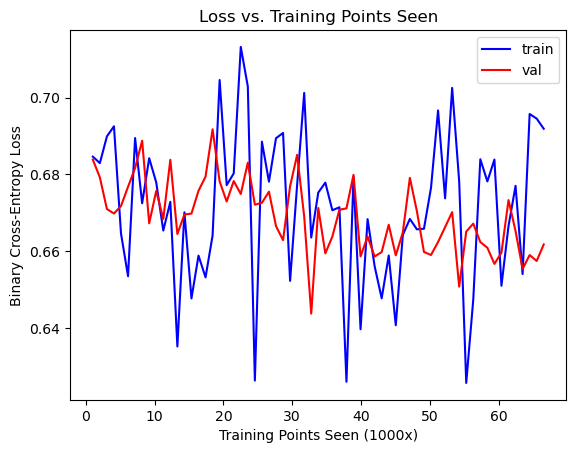

In [40]:
fig, ax = plt.subplots()

ax.plot(train_pts_seen_arr_1000, train_loss_arr, color="b",label="train")
ax.plot(train_pts_seen_arr_1000, val_loss_arr, color="r",label="val")

ax.set_title("Loss vs. Training Points Seen")
ax.set_xlabel("Training Points Seen (1000x)")
ax.set_ylabel("Binary Cross-Entropy Loss")
ax.legend()

# plt.savefig("plots/QPT/shots1/loss.pdf", bbox_inches="tight")
plt.show()

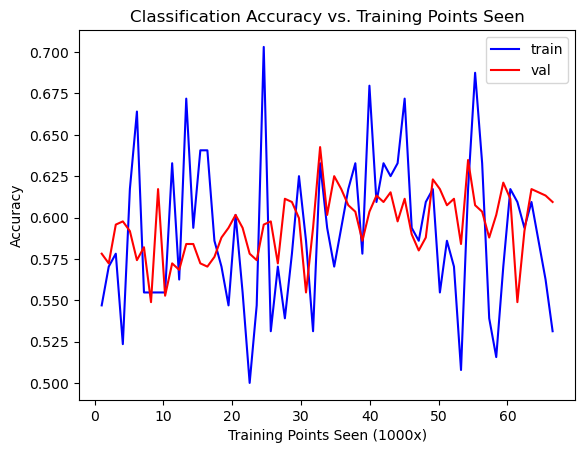

In [42]:
fig, ax = plt.subplots()

ax.plot(train_pts_seen_arr_1000, train_acc_arr, color="b",label="train")
ax.plot(train_pts_seen_arr_1000, val_acc_arr, color="r",label="val")

ax.set_title("Classification Accuracy vs. Training Points Seen")
ax.set_xlabel("Training Points Seen (1000x)")
ax.set_ylabel("Accuracy")
ax.legend()

# plt.savefig("plots/QPT/shots1/acc.pdf", bbox_inches="tight")
plt.show()

In [613]:
# val accuracy
val_x = val_dataset.x
val_true_y = val_dataset.y

with torch.no_grad():
    val_pred_y = model(val_x)

_, true_labels = torch.max(val_true_y, dim=-1)
_, pred_labels = torch.max(val_pred_y, dim=-1)   

val_correct_num = (true_labels == pred_labels).int().sum()

val_acc = val_correct_num / val_data_params["N_spiral"]

print(val_acc.item())

0.98681640625


In [614]:
# test accuracy
test_x = test_dataset.x
test_true_y = test_dataset.y

with torch.no_grad():
    test_pred_y = model(test_x)

_, true_labels = torch.max(test_true_y, dim=-1)
_, pred_labels = torch.max(test_pred_y, dim=-1)   

test_correct_num = (true_labels == pred_labels).int().sum()

test_acc = test_correct_num / test_data_params["N_spiral"]

print(test_acc.item())

0.99169921875


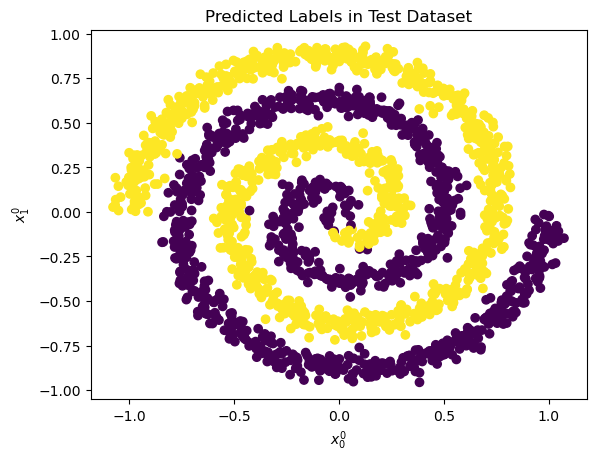

In [616]:
fig, ax = plt.subplots()

x_cpu = test_x.cpu()

ax.scatter(x_cpu[:, 0], x_cpu[:, 1], c=pred_labels.cpu()[:])
ax.set_title("Predicted Labels in Test Dataset")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")

# plt.savefig("plots/softmax_H2_L3_dm4/test_pred.pdf", bbox_inches="tight")
plt.show()

(101, 101) (101, 101)
(10201, 2)
(10201, 2, 1)


C:\Users\fhfds\AppData\Local\Temp\ipykernel_17544\2872038337.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


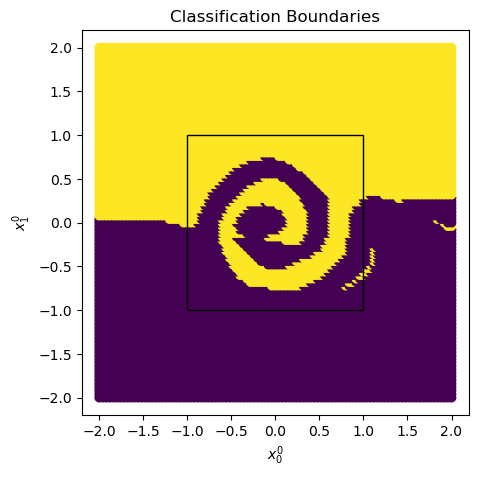

In [620]:
BOX_SIZE = 2
mesh_x1 = np.linspace(-BOX_SIZE, BOX_SIZE, 101)
mesh_x2 = np.linspace(-BOX_SIZE, BOX_SIZE, 101)
# full coordinate arrays
mesh_x1x1, mesh_x2x2 = np.meshgrid(mesh_x1, mesh_x2)

print(mesh_x1x1.shape, mesh_x2x2.shape)
mesh_x = np.stack([mesh_x1x1, mesh_x2x2])
mesh_x = mesh_x.reshape((2, -1)).T
print(mesh_x.shape)
# mesh_x = np.insert(mesh_x, 0, 2, axis=1) # BART-style <CLS>
mesh_x = np.expand_dims(mesh_x, axis=2)
print(mesh_x.shape)

mesh_x_tensor = torch.from_numpy(mesh_x).to(dtype=torch.float32, device=device)

mesh_pred_y = model(mesh_x_tensor)
_, mesh_pred_labels = torch.max(mesh_pred_y, dim=-1)   


fig, ax = plt.subplots()

# if BART-style <CLS>, change indices to 1&2
ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=mesh_pred_labels.cpu()[:])
ax.set_title("Classification Boundaries")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")

# https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
# Create a Rectangle patch
rect = patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor='black', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)


# ax.scatter(x_cpu[:, 0], x_cpu[:, 1])

fig.set_size_inches(5, 5)
# plt.savefig("plots/softmax_H2_L3_dm4/boundaries.pdf", bbox_inches="tight")
fig.set_dpi(100)
fig.show()

## 6) Model Parameters
In order to see the values, use `param.data` instead of `param.size()`.

In [151]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.size())

position_encoding.weight torch.Size([2, 4])
embedding.weight torch.Size([4, 1])
embedding.bias torch.Size([4])
encoder.encoder_units.0.ln1.weight torch.Size([4])
encoder.encoder_units.0.ln1.bias torch.Size([4])
encoder.encoder_units.0.multihead_attn.attention_heads.0.W_Q.weight torch.Size([2, 4])
encoder.encoder_units.0.multihead_attn.attention_heads.0.W_K.weight torch.Size([2, 4])
encoder.encoder_units.0.multihead_attn.attention_heads.0.W_V.weight torch.Size([2, 4])
encoder.encoder_units.0.multihead_attn.attention_heads.1.W_Q.weight torch.Size([2, 4])
encoder.encoder_units.0.multihead_attn.attention_heads.1.W_K.weight torch.Size([2, 4])
encoder.encoder_units.0.multihead_attn.attention_heads.1.W_V.weight torch.Size([2, 4])
encoder.encoder_units.1.ln1.weight torch.Size([4])
encoder.encoder_units.1.ln1.bias torch.Size([4])
encoder.encoder_units.1.multihead_attn.attention_heads.0.W_Q.weight torch.Size([2, 4])
encoder.encoder_units.1.multihead_attn.attention_heads.0.W_K.weight torch.Size([

## 7) Tracing the evolution of the input vector

In Ch. 5, we created the 2D mesh of points to visualize the classification
boundaries. Now, we will trace what happens to these points through the model
by sequentially applying the intermediate layers.

In [652]:
def attn_weight_plotter(mesh, attn_weight, head, attn_from, layer_id, base_save_path, save=False):
    # the head and attn_from are indexed from 1

    fig, ax = plt.subplots()
    scatter = ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=attn_weight[head-1][:, attn_from-1], cmap='viridis', alpha=0.5)
    ax.set_title(f"Attention Weights of $h={head}$, $l={layer_id}$")
    ax.set_xlabel(r"$x_1^0$")
    ax.set_ylabel(r"$x_2^0$")
    plt.colorbar(scatter, label=rf"$\alpha_{{{attn_from}1}} - \alpha_{{{attn_from}2}}$")
    
    if save:
        fig.savefig(base_save_path+"l"+str(layer_id)+"h"+str(head)+"from"+str(attn_from)+".pdf", bbox_inches="tight")
    else:
        fig.set_size_inches(10, 8)
        fig.set_dpi(100)
        plt.show()

In [653]:
def cluster_plotter(mesh_in, mesh_out, token_id, head, n_clusters=2, title=""):
    # token_id and head indexed from 1.
    # token_id can be (-1, 1, 2) where -1 means that both tokens will be concatenated
    # head index can be (-1, 1, 2) where -1 means that both heads will be considered

    if head < 0:
        head_id_range = range(model_params["dim_model"])
    elif head == 0:
        raise ValueError(f"Head cannot be 0!")
    elif head > model_params["num_heads"]:
        raise ValueError(f"Head = {head} > num_heads = {model_params['num_heads']}")
    else:
        head_id_range = range((head-1)*model_params["dim_model"]//model_params["num_heads"],
                              head*model_params["dim_model"]//model_params["num_heads"])
        
    if token_id < 0:
        mesh_to_be_clustered = mesh_out[:, :, head_id_range].flatten(start_dim=1)
    elif token_id == 0:
        raise ValueError(f"Token_id cannot be 0!")
    else:
        mesh_to_be_clustered = mesh_out[:, token_id-1, head_id_range]

    cluster_model = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_model.fit(mesh_to_be_clustered.cpu().detach().numpy())
    
    clusters = cluster_model.labels_

    # Map the cluster numbers to colors.
    clusters_colored = pd.Series(clusters).map({
        0: "r",
        1: "b",
        2: "y",
        3: "g",
        4: "cyan",
        5: "magenta"
    })
    
    fig, ax = plt.subplots()
    ax.scatter(mesh_in[:, 0], mesh_in[:, 1], c=clusters_colored, alpha=0.5)

    if title != "":
        ax.set_title(title)

    ax.set_xlabel(r"$x_1^0$")
    ax.set_ylabel(r"$x_2^0$")

    fig.set_size_inches(8, 8)
    fig.set_dpi(100)
    plt.show()

In [654]:
def cluster_artist(mesh_in, mesh_out, token_id, head, n_clusters=2, title="", fig=None, ax=None):
    # token_id and head indexed from 0.
    # token_id can be (-1, 0, 1) where -1 means that both tokens will be concatenated
    #   - for convenience, 2 is also accepted and set to -1.
    # head index can be (-1, 0, 1) where -1 means that both heads will be considered
    #   - for convenience, 2 is also accepted and set to -1.

    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    #### adapted from cluster_plotter ####
    if head < 0 or head == model_params["num_heads"]:
        head_id_range = range(model_params["dim_model"])
    # elif head == 0:
    #     raise ValueError(f"Head cannot be 0!")
    elif head > model_params["num_heads"]:
        raise ValueError(f"Head = {head} > num_heads = {model_params['num_heads']}")
    else:
        head_id_range = range((head)*model_params["dim_model"]//model_params["num_heads"],
                              (head+1)*model_params["dim_model"]//model_params["num_heads"])
        
    if token_id < 0 or token_id == mesh_out.shape[1]:
        mesh_to_be_clustered = mesh_out[:, :, head_id_range].flatten(start_dim=1)
    # elif token_id == 0:
    #     raise ValueError(f"Token_id cannot be 0!")
    else:
        mesh_to_be_clustered = mesh_out[:, token_id, head_id_range]


    # cluster_model_init = KMeans(n_clusters=2, n_init=10)
    # cluster_model_init.fit(mesh_to_be_clustered[:1].cpu().detach().numpy())
    # init_centroids = cluster_model_init.cluster_centers_

    cluster_model = KMeans(n_clusters=n_clusters, n_init='auto')
    cluster_model.fit(mesh_to_be_clustered.cpu().detach().numpy())
    
    clusters = cluster_model.labels_

    # Map the cluster numbers to colors.
    clusters_colored = pd.Series(clusters).map({
        0: "r",
        1: "b",
        2: "y",
        3: "g",
        4: "cyan",
        5: "magenta"
    })
    

    ax.scatter(mesh_in[:, 0], mesh_in[:, 1], c=clusters_colored, alpha=0.5)

    if title != "":
        ax.set_title(title)

    ax.set_xlabel(r"$x_1^0$")
    ax.set_ylabel(r"$x_2^0$", labelpad=-10)

    return fig, ax

### 7.1) Embedding Layer

In [655]:
mesh_post_embedding = model.embedding.forward(mesh_x_tensor)
print(mesh_post_embedding.size())

torch.Size([10201, 2, 4])


In [656]:
# In order to make sense of these 16 dimensional vectors, we'll cluster
# them with K-Means.
n_cluster_post_embedding = 4
clustermodel_post_embedding = KMeans(n_clusters=n_cluster_post_embedding, n_init=10)

# let's just take the first vector for now [NOTE changed]
# we concatenate two vectors to a single vector per point
clustermodel_post_embedding.fit(mesh_post_embedding.flatten(start_dim=1).cpu().detach().numpy())
clusters_post_embedding = clustermodel_post_embedding.labels_

In [657]:
# Map the cluster numbers to colors.
clusters_post_embedding = pd.Series(clusters_post_embedding).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "cyan",
    5: "magenta"
})

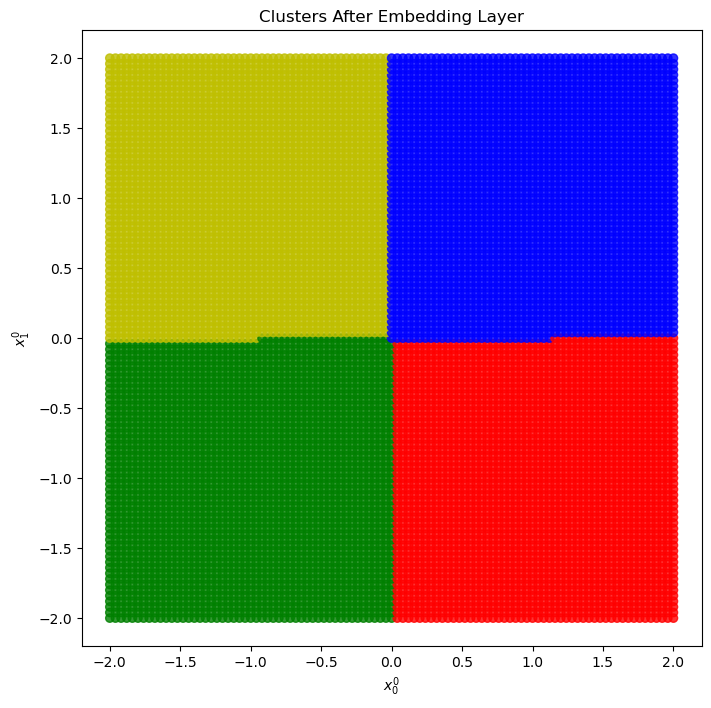

In [658]:
fig, ax = plt.subplots()
ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=clusters_post_embedding, alpha=0.8)
ax.set_title("Clusters After Embedding Layer")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")
fig.set_size_inches(8, 8)
fig.set_dpi(100)
plt.show()


### 7.2) Position Encoding Layer

In [659]:
mesh_post_positionenc = mesh_post_embedding + model.position_encoding(model.seq_idx_arr)

### 7.3) Encoder Layers

For this toy model, since we have two attention heads in every self-attention
layer, and since $d=16$, we note that in order to investigate how different
attention heads contribute to the model, we should pick the first half of the
concatenated vector (indices $[0:8]$) for the first head, and the second half
(indices $[8:16]$) for the second head.

#### 7.3.1) First Encoder Unit

In [660]:
mesh_post_first_encoder, attn_w_first_encoder = model.encoder.encoder_units[0].forward(mesh_post_positionenc, return_attention_weights=True)
print(mesh_post_first_encoder.size())

print(attn_w_first_encoder[0].size()) # first head

# an array in length of num_heads, where every element is
# [idx, seq_length] and for that index, the scalar value is
# 1 if the attention weight of 0th token/coordinate is 1 and 1th coordinate 0, and
# -1 if the attention weight of 0th coordinate is 0 and 1th coordinate 1.
attn_w_distr_first_encoder = []

for head in attn_w_first_encoder:
    attn_w_distr_first_encoder.append((head[:, :, 0] - head[:, :, 1]).cpu().detach().numpy())

print(attn_w_distr_first_encoder[0].shape)
print(attn_w_distr_first_encoder[0][0])

print(attn_w_first_encoder[0][0])
print(attn_w_first_encoder[0][0, :, 0] - attn_w_first_encoder[0][0, :, 1])


torch.Size([10201, 2, 4])
torch.Size([10201, 2, 2])
(10201, 2)
[-0.056602   -0.03513756]
tensor([[0.4717, 0.5283],
        [0.4824, 0.5176]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0566, -0.0351], device='cuda:0', grad_fn=<SubBackward0>)


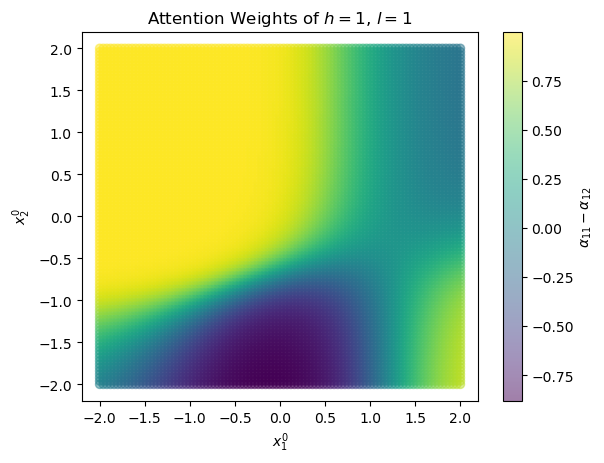

In [664]:

# fig, ax = plt.subplots()

# attn_from = 0
# scatter = ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=attn_w_distr_first_encoder[1][:, attn_from], cmap='viridis', alpha=0.5)
# ax.set_title("Attention Weights of $h=2$, $l=1$")
# ax.set_xlabel(r"$x_0^0$")
# ax.set_ylabel(r"$x_1^0$")
# plt.colorbar(scatter, label=r"$\alpha_{00} - \alpha_{01}$")

# fig.set_size_inches(10, 8)
# fig.set_dpi(100)
# plt.show()

attn_weight_plotter(mesh_x, attn_w_distr_first_encoder, head=1, attn_from=1, layer_id=1,
                    base_save_path="plots/softmax_H2_L3_dm4/attn/", save=True)

In [ ]:
n_cluster_post_first_encoder = 2
clustermodel_post_first_encoder = KMeans(n_clusters=n_cluster_post_first_encoder, n_init=10)

# we concatenate two vectors to a single vector per point
clustermodel_post_first_encoder.fit(mesh_post_first_encoder[:, :, :].flatten(start_dim=1).cpu().detach().numpy())
clusters_post_first_encoder = clustermodel_post_first_encoder.labels_

In [665]:
# Map the cluster numbers to colors.
clusters_post_first_encoder = pd.Series(clusters_post_first_encoder).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "cyan",
    5: "magenta"
})

NameError: name 'clusters_post_first_encoder' is not defined

In [679]:
def layer_cluster_plotter(mesh_in, mesh_out, n_clusters=2, title="Clusters", save_path_with_pdf=None, save=False):
    
    # figure count is [num_tokens+1] x [num_heads+1]
    # where +1 is used for every token/head involved

    fig, axs = plt.subplots(mesh_out.shape[1]+1, model_params["num_heads"]+1)


    for j in range(mesh_out.shape[1]+1):
        for h in range(model_params["num_heads"]+1):
            
            title_token_str = "joint tokens" if j == mesh_out.shape[1] else f"token $j={j+1}$"
            head_str = "joint heads" if h == model_params["num_heads"] else f"$h={h+1}$"

            fig, axs[j, h] = cluster_artist(mesh_in, mesh_out, j, h, n_clusters,
            fig=fig, ax=axs[j, h], title=f"({title_token_str}, {head_str})")



    fig.suptitle(title)
    fig.set_size_inches(12, 12)
    
    if save:
        fig.savefig(save_path_with_pdf)
    else:
        fig.set_dpi(100)
        fig.tight_layout()
        plt.show()
    

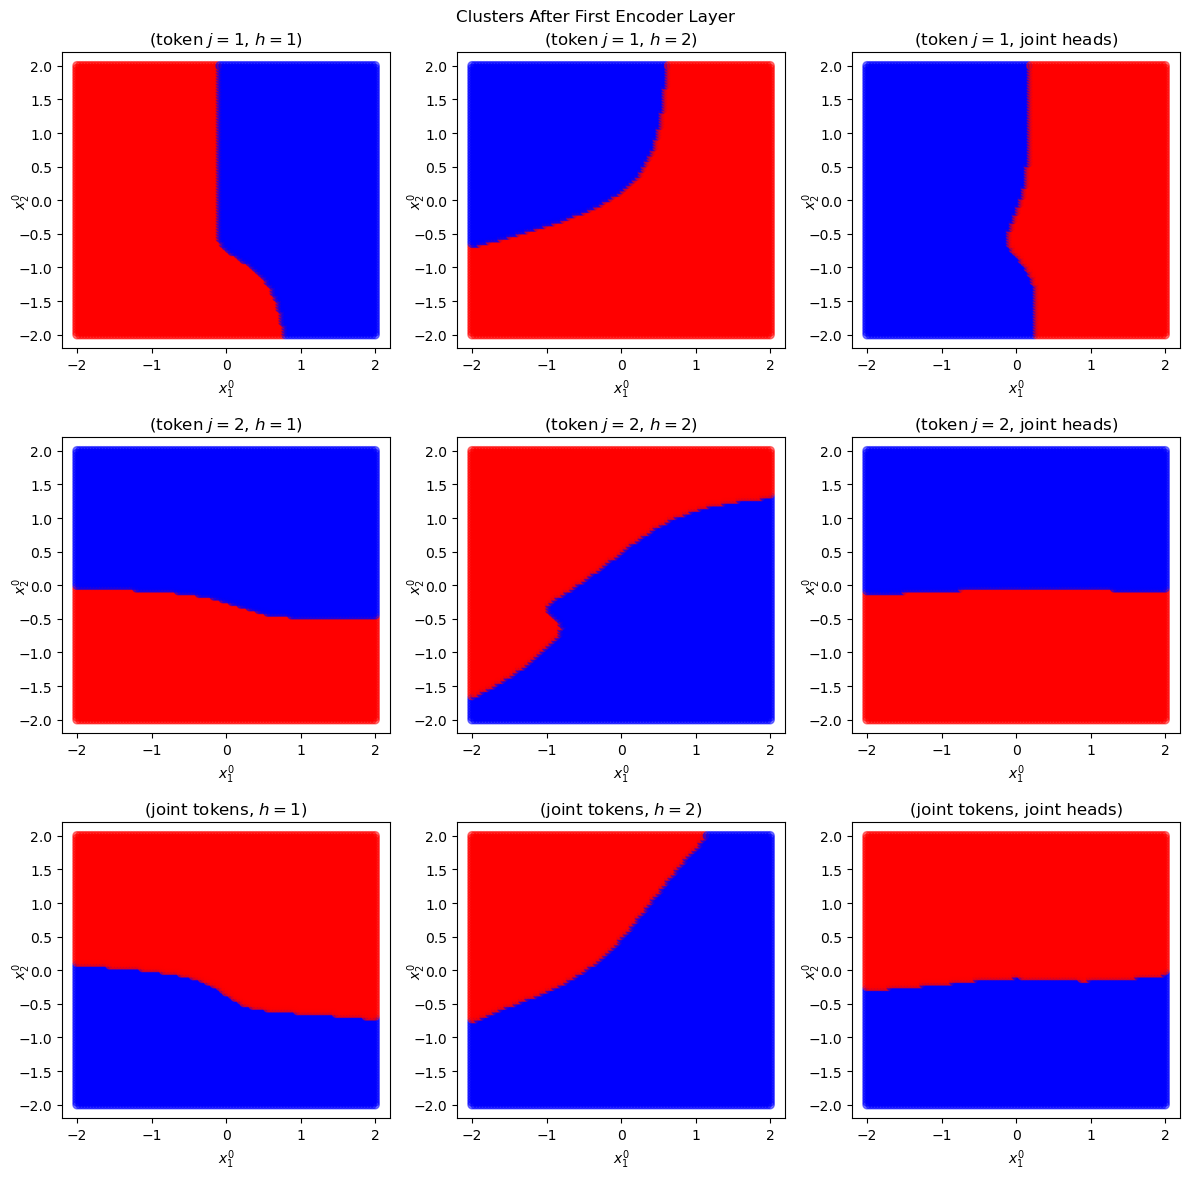

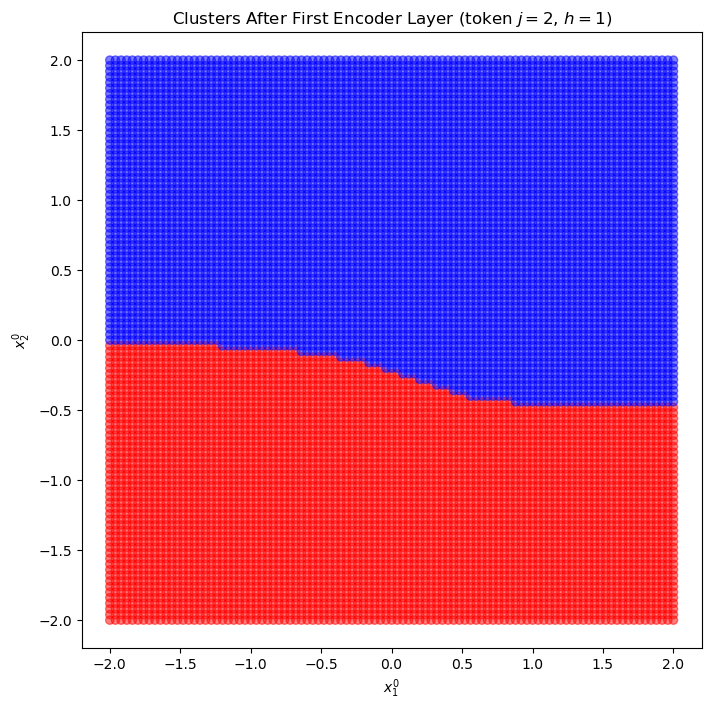

In [681]:
# fig, ax = plt.subplots()
# ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=clusters_post_first_encoder, alpha=0.5)
# ax.set_title("Clusters After First Encoder Layer (from outputs of both heads)")
# # ax.set_title("Clusters After First Encoder Layer (from outputs of $2^{nd}$ head)")
# ax.set_xlabel(r"$x_0^0$")
# ax.set_ylabel(r"$x_1^0$")

# fig.set_size_inches(8, 8)
# fig.set_dpi(100)
# plt.show()

layer_cluster_plotter(mesh_x, mesh_post_first_encoder, title="Clusters After First Encoder Layer",
                      save_path_with_pdf="plots/softmax_H2_L3_dm4/clusterL1.pdf", save=False)

token_id = 2
head_id = 1

title_token_str = "joint tokens" if token_id < 0 else f"token $j={token_id}$"
head_str = "joint heads" if head_id < 0 else f"$h={head_id}$"

plot_title = f"Clusters After First Encoder Layer ({title_token_str}, {head_str})"
cluster_plotter(mesh_x, mesh_post_first_encoder, token_id, head_id, n_clusters=2, title=plot_title)

#### 7.3.2) Second Encoder Unit

In [682]:
mesh_post_second_encoder, attn_w_second_encoder = model.encoder.encoder_units[1].forward(mesh_post_first_encoder, return_attention_weights=True)
print(mesh_post_second_encoder.size())
print(attn_w_second_encoder[0].size()) # first head
print(attn_w_second_encoder[1].size()) # second head

attn_w_distr_second_encoder = []
attn_w_distr_second_encoder.append((attn_w_second_encoder[0][:, :, 0] - attn_w_second_encoder[0][:, :, 1]).cpu().detach().numpy())
attn_w_distr_second_encoder.append((attn_w_second_encoder[1][:, :, 0] - attn_w_second_encoder[1][:, :, 1]).cpu().detach().numpy())


torch.Size([10201, 2, 4])
torch.Size([10201, 2, 2])
torch.Size([10201, 2, 2])


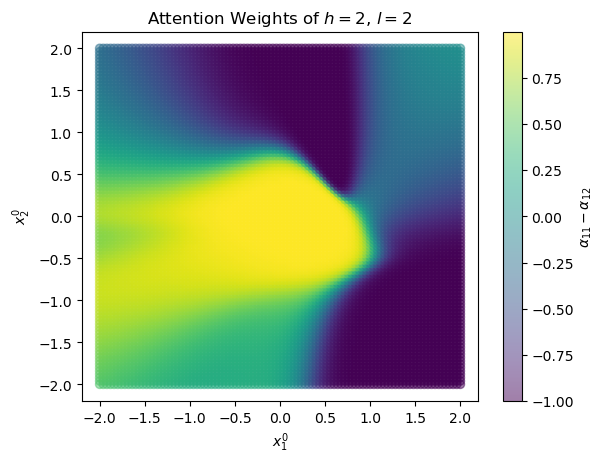

In [686]:
# fig, ax = plt.subplots()

# attn_from = 0
# scatter = ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=attn_w_distr_second_encoder[0][:, attn_from], cmap='viridis', alpha=0.5)
# ax.set_title("Attention Weights of $h=1$, $l=2$")
# ax.set_xlabel(r"$x_0^0$")
# ax.set_ylabel(r"$x_1^0$")
# plt.colorbar(scatter, label=r"$\alpha_{00} - \alpha_{01}$")

# fig.set_size_inches(10, 8)
# fig.set_dpi(100)
# plt.show()

# attn_weight_plotter(mesh_x, attn_w_distr_second_encoder, 2, 2, 2)
attn_weight_plotter(mesh_x, attn_w_distr_second_encoder, head=2, attn_from=1, layer_id=2,
                    base_save_path="plots/softmax_H2_L3_dm4/attn/", save=True)

In [104]:
n_cluster_post_second_encoder = 2
clustermodel_post_second_encoder = KMeans(n_clusters=n_cluster_post_second_encoder, n_init=10)

# we concatenate two vectors to a single vector per point
clustermodel_post_second_encoder.fit(mesh_post_second_encoder[:, :, :].flatten(start_dim=1).cpu().detach().numpy())
clusters_post_second_encoder = clustermodel_post_second_encoder.labels_

In [687]:
# Map the cluster numbers to colors.
clusters_post_second_encoder = pd.Series(clusters_post_second_encoder).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "cyan",
    5: "magenta"
})

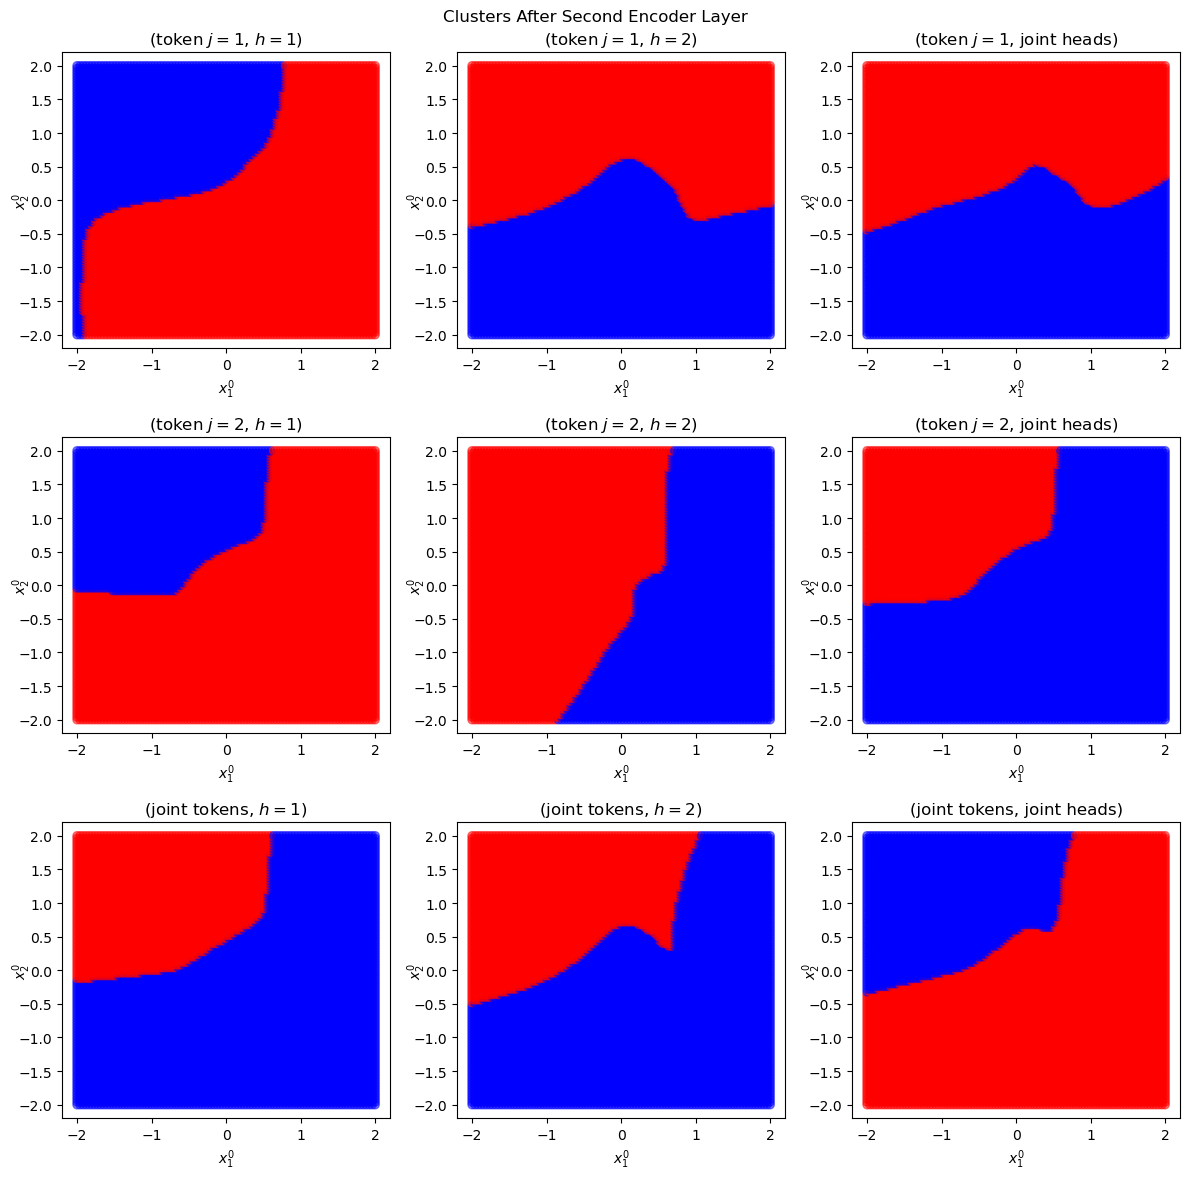

In [688]:
layer_cluster_plotter(mesh_x, mesh_post_second_encoder, title="Clusters After Second Encoder Layer")

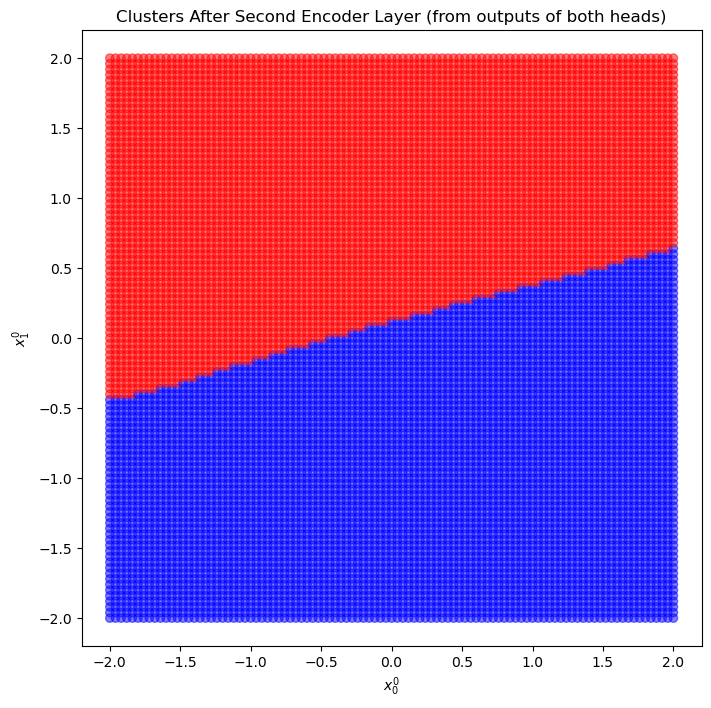

In [107]:
fig, ax = plt.subplots()
ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=clusters_post_second_encoder, alpha=0.5)
ax.set_title("Clusters After Second Encoder Layer (from outputs of both heads)")
# ax.set_title("Clusters After Second Encoder Layer (from outputs of $1^{st}$ head)")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")

fig.set_size_inches(8, 8)
fig.set_dpi(100)
plt.show()

#### 7.3.3) Third Encoder Unit

In [689]:
mesh_post_third_encoder, attn_w_third_encoder = model.encoder.encoder_units[2].forward(mesh_post_second_encoder, return_attention_weights=True)
print(mesh_post_third_encoder.size())
print(attn_w_third_encoder[0].size()) # first head
print(attn_w_third_encoder[1].size()) # second head

attn_w_distr_third_encoder = []
attn_w_distr_third_encoder.append((attn_w_third_encoder[0][:, :, 0] - attn_w_third_encoder[0][:, :, 1]).cpu().detach().numpy())
attn_w_distr_third_encoder.append((attn_w_third_encoder[1][:, :, 0] - attn_w_third_encoder[1][:, :, 1]).cpu().detach().numpy())

torch.Size([10201, 2, 4])
torch.Size([10201, 2, 2])
torch.Size([10201, 2, 2])


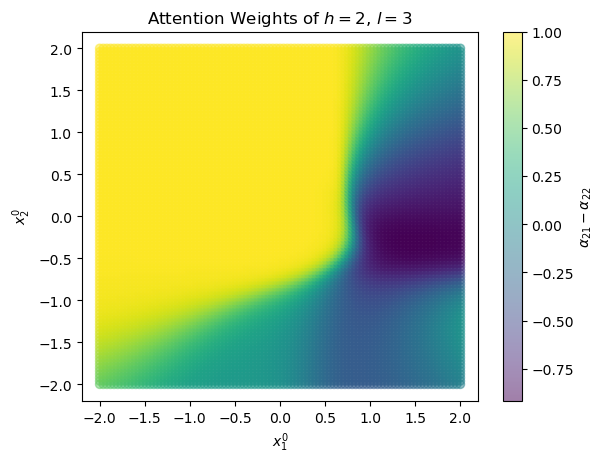

In [693]:
# fig, ax = plt.subplots()

# attn_from = 0
# scatter = ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=attn_w_distr_third_encoder[1][:, attn_from], cmap='viridis', alpha=0.5)
# ax.set_title("Attention Weights of $h=2$, $l=3$")
# ax.set_xlabel(r"$x_0^0$")
# ax.set_ylabel(r"$x_1^0$")
# plt.colorbar(scatter, label=r"$\alpha_{00} - \alpha_{01}$")

# fig.set_size_inches(10, 8)
# fig.set_dpi(100)
# plt.show()

# attn_weight_plotter(mesh_x, attn_w_distr_third_encoder, 1, 2, 3)
attn_weight_plotter(mesh_x, attn_w_distr_second_encoder, head=2, attn_from=2, layer_id=3,
                    base_save_path="plots/softmax_H2_L3_dm4/attn/", save=True)

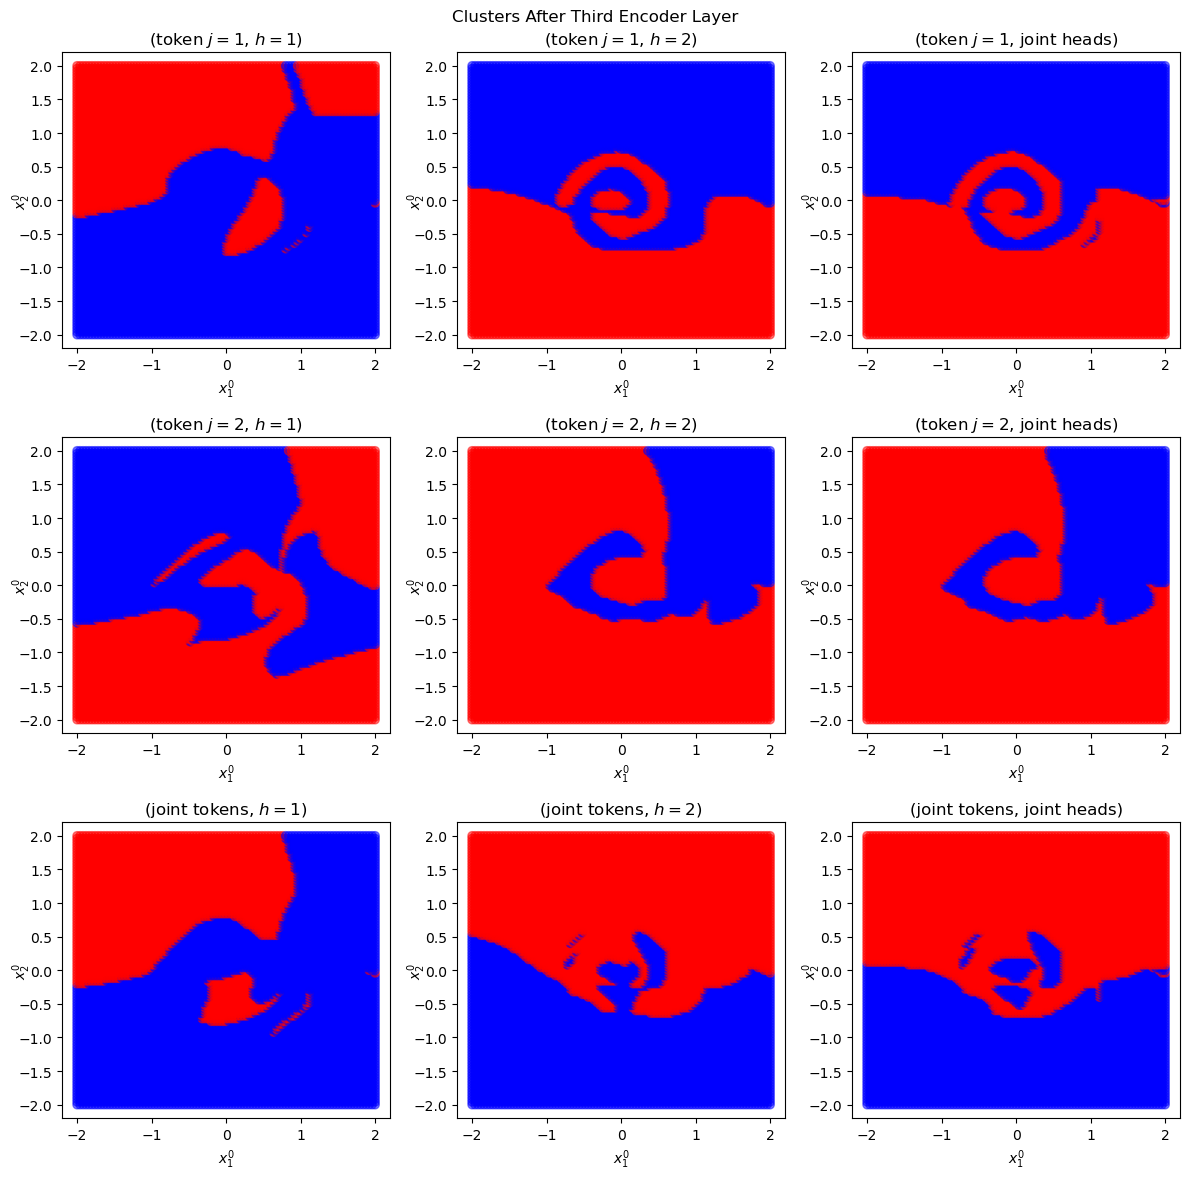

In [694]:
layer_cluster_plotter(mesh_x, mesh_post_third_encoder, title="Clusters After Third Encoder Layer")

In [111]:
n_cluster_post_third_encoder = 2
clustermodel_post_third_encoder = KMeans(n_clusters=n_cluster_post_third_encoder, n_init=10)

# NOTE!! let's use the first vector since we just use that for classification
clustermodel_post_third_encoder.fit(mesh_post_third_encoder[:, 0, :].cpu().detach().numpy())
clusters_post_third_encoder = clustermodel_post_third_encoder.labels_

In [112]:
# Map the cluster numbers to colors.
clusters_post_third_encoder = pd.Series(clusters_post_third_encoder).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "cyan",
    5: "magenta"
})

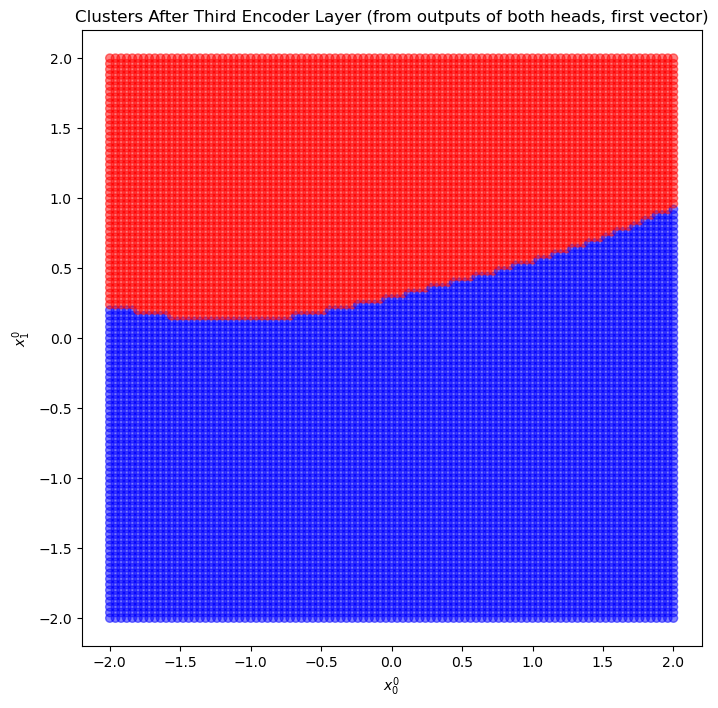

In [113]:
fig, ax = plt.subplots()
ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=clusters_post_third_encoder, alpha=0.5)

ax.set_title("Clusters After Third Encoder Layer (from outputs of both heads, first vector)")
# ax.set_title("Clusters After Third Encoder Layer (from outputs of $1^{st}$ head)")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")

fig.set_size_inches(8, 8)
fig.set_dpi(100)
plt.show()

### 7.4) Output Layer

In [695]:
mesh_post_output = model.output.forward(mesh_post_third_encoder)
print(mesh_post_output.size())

torch.Size([10201, 2, 2])


In [696]:
n_cluster_post_output = 2
clustermodel_post_output = KMeans(n_clusters=n_cluster_post_output, n_init=10)

# NOTE!! let's use the first vector since we just use that for classification
clustermodel_post_output.fit(mesh_post_output[:, 0, :].cpu().detach().numpy())
clusters_post_output = clustermodel_post_output.labels_

In [697]:
# Map the cluster numbers to colors.
clusters_post_output = pd.Series(clusters_post_output).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g",
    4: "cyan",
    5: "magenta"
})

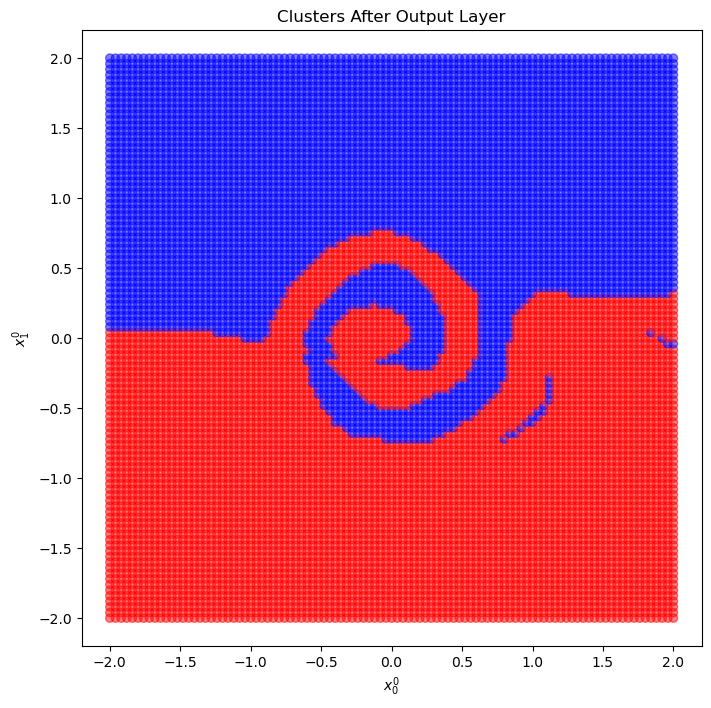

In [698]:
fig, ax = plt.subplots()
ax.scatter(mesh_x[:, 0], mesh_x[:, 1], c=clusters_post_output, alpha=0.5)
ax.set_title("Clusters After Output Layer")
ax.set_xlabel(r"$x_0^0$")
ax.set_ylabel(r"$x_1^0$")

fig.set_size_inches(8, 8)
fig.set_dpi(100)
plt.show()

## 8) $W_Q W_K^T$ Plots

MultiheadAttention(
  (attention_heads): ModuleList(
    (0-1): 2 x SelfAttentionLayer(
      (W_Q): Linear(in_features=4, out_features=2, bias=False)
      (W_K): Linear(in_features=4, out_features=2, bias=False)
      (W_V): Linear(in_features=4, out_features=2, bias=False)
    )
  )
)
l = 0, h = 0
torch.Size([2, 4])
l = 0, h = 1
torch.Size([2, 4])
l = 1, h = 0
torch.Size([2, 4])
l = 1, h = 1
torch.Size([2, 4])
l = 2, h = 0
torch.Size([2, 4])
l = 2, h = 1
torch.Size([2, 4])


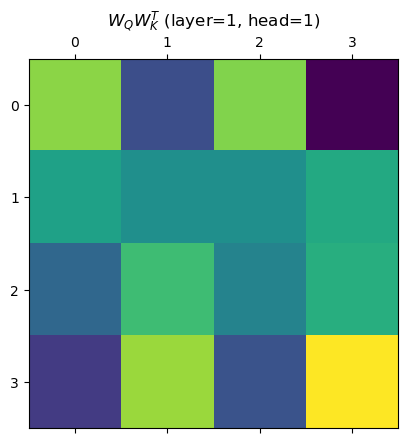

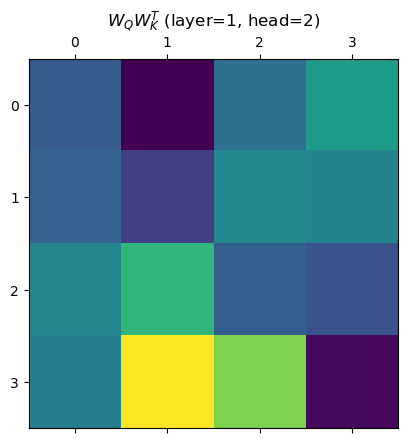

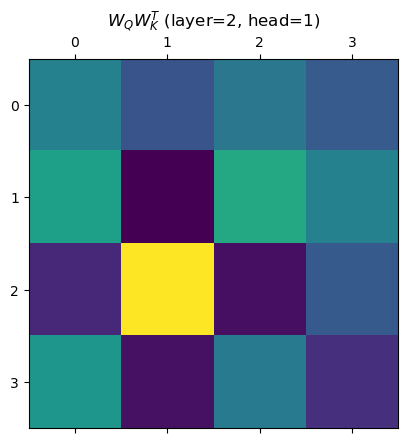

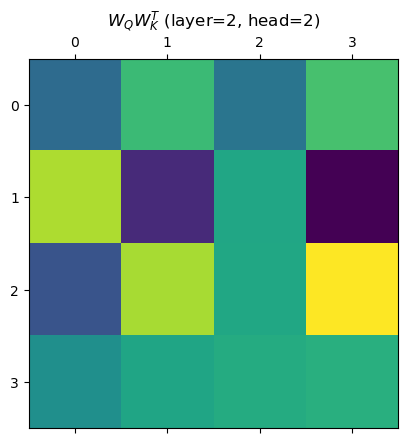

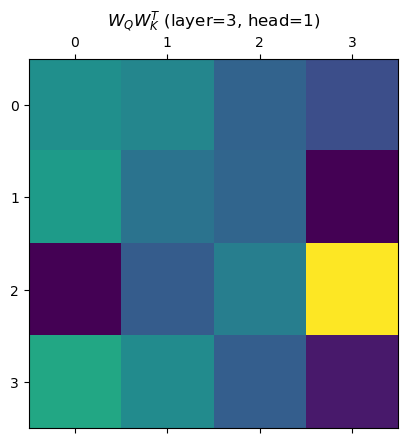

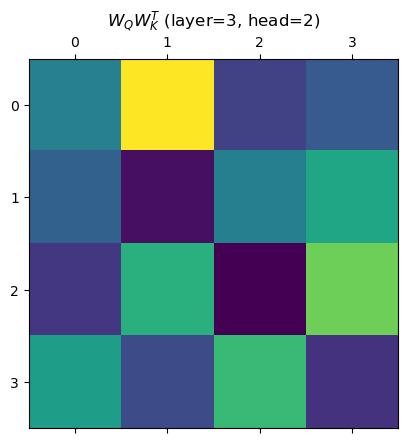

In [699]:
print(model.encoder.encoder_units[0].multihead_attn)

for layer_id in range(model_params["num_layers"]):

    for h in range(model_params["num_heads"]):
        print(f"l = {layer_id}, h = {h}")

        head = model.encoder.encoder_units[layer_id].multihead_attn.attention_heads[h]
        mat = head.W_Q.state_dict()["weight"].T @ head.W_K.state_dict()["weight"]

        print(head.W_Q.state_dict()["weight"].size())
        fig, ax = plt.subplots()
        ax.matshow(mat.cpu().detach().numpy())
        ax.set_title(f"$W_{{Q}} W_{{K}}^T$ (layer={layer_id+1}, head={h+1})")

# for head in model.encoder.encoder_units[0].multihead_attn.attention_heads:
#     mat = head.W_Q.state_dict()["weight"] @ head.W_K.state_dict()["weight"].T
#     print(mat)

#     fig, ax = plt.subplots()
#     ax.matshow(mat.cpu().detach().numpy())
#     ax.set_title(f"(h={head})")